In [1]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
import keras
from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Useful Functions 

In [2]:
#Function to normalize columns
def normalize_numeric_minmax(df, name):
    if(df[name].max() > 0):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
    else:
        df[name] = df[name].astype(np.float32)

In [3]:
# one-hot cooding of categorical columns

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name]).astype(np.float32)
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [4]:
# create a function called encodeLabelBinarizer

encodeLabelBinary = lambda x: 0 if x == 'normal.' else 1

In [5]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
import collections
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [6]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_



In [7]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [8]:
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    

# Training and prediction with classic regression and classification model

## Data Processing 

In [9]:
#Read network_intrusion_data.csv file and load data into network_df dataframe 
network_df= pd.read_csv('network_intrusion_data.csv')

In [10]:
#Drop any row with missing values
network_df = network_df.dropna()

In [11]:
#Add column headers to the data in the dataframe
network_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [12]:
#Select colums for feature
features_df = network_df[['duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
                          
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
                          
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']]

In [13]:
#Label column
label_df = network_df[['outcome']]

In [14]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(features_df,"duration") 
normalize_numeric_minmax(features_df,"src_bytes") 
normalize_numeric_minmax(features_df,"dst_bytes") 
normalize_numeric_minmax(features_df,"wrong_fragment") 
normalize_numeric_minmax(features_df,"urgent") 

normalize_numeric_minmax(features_df,"hot") 
normalize_numeric_minmax(features_df,"num_failed_logins") 
normalize_numeric_minmax(features_df,"num_compromised") 
normalize_numeric_minmax(features_df,"num_root") 
normalize_numeric_minmax(features_df,"num_file_creations") 
normalize_numeric_minmax(features_df,"num_shells") 
normalize_numeric_minmax(features_df,"num_access_files") 
normalize_numeric_minmax(features_df,"num_outbound_cmds") 

normalize_numeric_minmax(features_df,"count") 
normalize_numeric_minmax(features_df,"srv_count") 
normalize_numeric_minmax(features_df,"serror_rate") 
normalize_numeric_minmax(features_df,"rerror_rate") 
normalize_numeric_minmax(features_df,"srv_rerror_rate")  
normalize_numeric_minmax(features_df,"same_srv_rate") 
normalize_numeric_minmax(features_df,"diff_srv_rate") 
normalize_numeric_minmax(features_df,"srv_diff_host_rate") 
normalize_numeric_minmax(features_df,"dst_host_count") 
normalize_numeric_minmax(features_df,"dst_host_srv_count") 
normalize_numeric_minmax(features_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(features_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(features_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(features_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(features_df,"dst_host_serror_rate") 
normalize_numeric_minmax(features_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(features_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(features_df,"dst_host_srv_rerror_rate") 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
#One hot coding discrete values (9)
encode_text_dummy(features_df,"protocol_type") 
encode_text_dummy(features_df,"service") 
encode_text_dummy(features_df,"flag") 
encode_text_dummy(features_df,"land") 

encode_text_dummy(features_df,"logged_in") 
encode_text_dummy(features_df,"root_shell") 
encode_text_dummy(features_df,"su_attempted") 
encode_text_dummy(features_df,"is_host_login") 
encode_text_dummy(features_df,"is_guest_login") 

In [16]:
#Reduce the data set as the original is too large for classics to run for testing. Remove this section later
#features_df = features_df[0:10000]
#label_df = label_df[0:10000]

In [17]:
#Binary encode the label column
label_df['outcome'] = label_df['outcome'].apply(encodeLabelBinary)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
#Split for training and testing
x_train, x_test, y_train, y_test = train_test_split(features_df, label_df['outcome'] , test_size=0.2, random_state=42)

## Logistic Regression

In [19]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_train, y_train)

y_pred_logistic = Log_reg_model.predict(x_test)

In [20]:
# Metrics
from sklearn import metrics

score_acc_log = metrics.accuracy_score(y_test, y_pred_logistic)
print("Accuracy score: {}".format(score_acc_log))

score_precision_log = metrics.precision_score(y_test, y_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_precision_log))

score_recall_log = metrics.recall_score(y_test, y_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_recall_log))

score_f1_log = metrics.f1_score(y_test, y_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_f1_log))

Accuracy score: 0.9946257236549128
Precision score: 0.9946828323036672
Recall score: 0.9946257236549128
F1 score: 0.9946408290044061


In [21]:
cm_log = confusion_matrix(y_test, y_pred_logistic)
print(cm_log)

[[19248   120]
 [  411 79025]]


In [22]:
outcome = encode_text_index(label_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
outcome

array([0, 1])

Plotting confusion matrix


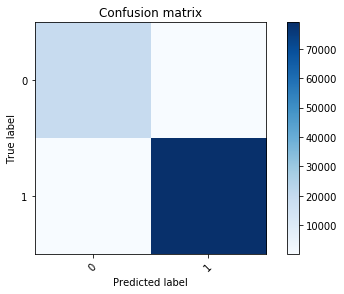

In [24]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_log, outcome)
plt.show()

In [25]:
print(classification_report(y_test, y_pred_logistic))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99     19368
          1       1.00      0.99      1.00     79436

avg / total       0.99      0.99      0.99     98804



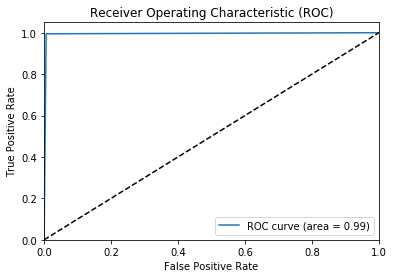

In [26]:
pred_log = Log_reg_model.predict(x_test)
pred_log = pred_log[:]
plot_roc(pred_log,y_test)

## Classification Models 

### KNN

In [27]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(x_train, y_train) 

y_pred_knn = knn.predict(x_test)

In [28]:
# Metrics
from sklearn import metrics

score_knn_acc = metrics.accuracy_score(y_test, y_pred_knn)
print("Accuracy score: {}".format(score_knn_acc))

score_knn_precision = metrics.precision_score(y_test, y_pred_knn, average= "weighted")
print("Precision score: {}".format(score_knn_precision))

score_knn_recall = metrics.recall_score(y_test, y_pred_knn, average= "weighted")
print("Recall score: {}".format(score_knn_recall))

score_knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
print("F1 score: {}".format(score_knn_f1))

Accuracy score: 0.9995546738998421
Precision score: 0.9995549353996092
Recall score: 0.9995546738998421
F1 score: 0.9995547520894394


In [29]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
print(cm_knn)

[[19355    13]
 [   31 79405]]


In [30]:
outcome = encode_text_index(label_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [31]:
outcome

array([0, 1])

Plotting confusion matrix


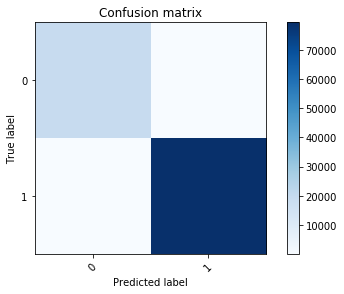

In [32]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_knn, outcome)
plt.show()

In [33]:
print(classification_report(y_test, y_pred_knn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



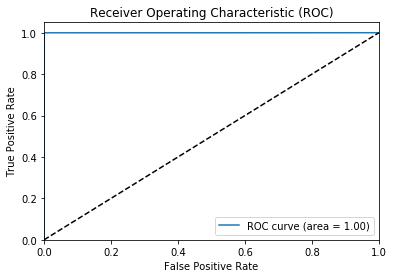

In [34]:
pred_knn = knn.predict(x_test)
pred_knn = pred_knn[:]
plot_roc(pred_knn,y_test)

### SVM

In [35]:
# SVM
from sklearn.svm import SVC

svm_model = SVC(kernel="linear")

svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_test)

In [36]:
# Metrics

score_svm_acc = metrics.accuracy_score(y_test, y_pred_svm)
print("Accuracy score: {}".format(score_svm_acc))

score_svm_precision = metrics.precision_score(y_test, y_pred_svm, average= "weighted")
print("Precision score: {}".format(score_svm_precision))

score_svm_recall = metrics.recall_score(y_test, y_pred_svm, average= "weighted")
print("Recall score: {}".format(score_svm_recall))

score_svm_f1 = metrics.f1_score(y_test, y_pred_svm, average= "weighted")
print("F1 score: {}".format(score_svm_f1))

Accuracy score: 0.9983300271244079
Precision score: 0.9983315628157213
Recall score: 0.9983300271244079
F1 score: 0.9983305969065448


In [37]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)

[[19303    65]
 [  100 79336]]


In [38]:
outcome = encode_text_index(label_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [39]:
outcome

array([0, 1])

Plotting confusion matrix


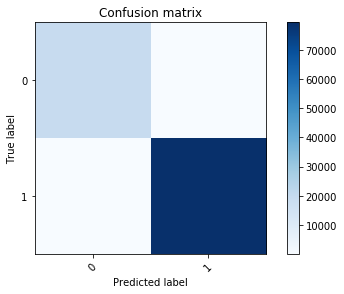

In [40]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_svm, outcome)
plt.show()

In [41]:
print(classification_report(y_test, y_pred_svm))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



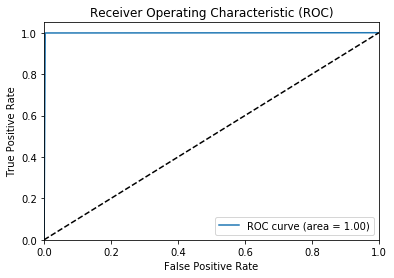

In [42]:
pred_svm = svm_model.predict(x_test)
pred_svm = pred_svm[:]
plot_roc(pred_svm,y_test)

### Gaussian Naive Bayes

In [43]:
#GNB
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()

gnb_model.fit(x_train, y_train)

y_pred_gnb = gnb_model.predict(x_test)

In [44]:
# Metrics

score_gnb_acc = metrics.accuracy_score(y_test, y_pred_gnb)
print("Accuracy score: {}".format(score_gnb_acc))

score_gnb_precision = metrics.precision_score(y_test, y_pred_gnb, average= "weighted")
print("Precision score: {}".format(score_gnb_precision))

score_gnb_recall = metrics.recall_score(y_test, y_pred_gnb, average= "weighted")
print("Recall score: {}".format(score_gnb_recall))

score_gnb_f1 = metrics.f1_score(y_test, y_pred_gnb, average= "weighted")
print("F1 score: {}".format(score_gnb_f1))

Accuracy score: 0.9489089510546131
Precision score: 0.9593017637420566
Recall score: 0.9489089510546131
F1 score: 0.9509965159983609


In [45]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
print(cm_gnb)

[[19340    28]
 [ 5020 74416]]


In [46]:
outcome = encode_text_index(label_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [47]:
outcome

array([0, 1])

Plotting confusion matrix


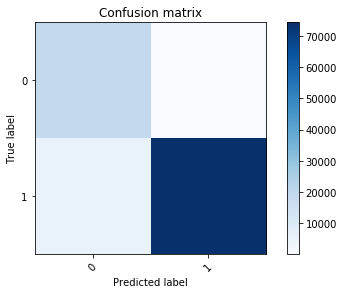

In [48]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_gnb, outcome)
plt.show()

In [49]:
print(classification_report(y_test, y_pred_gnb))

             precision    recall  f1-score   support

          0       0.79      1.00      0.88     19368
          1       1.00      0.94      0.97     79436

avg / total       0.96      0.95      0.95     98804



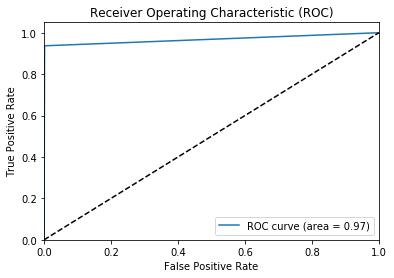

In [50]:
pred_gnb = gnb_model.predict(x_test)
pred_gnb = pred_gnb[:]
plot_roc(pred_gnb,y_test)

# Fully connected Neural Network and Convolutional Neural Network

## Data Processing 

In [51]:
#Read network_intrusion_data.csv file and load data into network_df dataframe 
network_nn_df= pd.read_csv('network_intrusion_data.csv')

In [52]:
#Drop any row with missing values
network_nn_df = network_nn_df.dropna()

In [53]:
#Add column headers to the data in the dataframe
network_nn_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [54]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(network_nn_df,"duration") 
normalize_numeric_minmax(network_nn_df,"src_bytes") 
normalize_numeric_minmax(network_nn_df,"dst_bytes") 
normalize_numeric_minmax(network_nn_df,"wrong_fragment") 
normalize_numeric_minmax(network_nn_df,"urgent") 

normalize_numeric_minmax(network_nn_df,"hot") 
normalize_numeric_minmax(network_nn_df,"num_failed_logins") 
normalize_numeric_minmax(network_nn_df,"num_compromised") 
normalize_numeric_minmax(network_nn_df,"num_root") 
normalize_numeric_minmax(network_nn_df,"num_file_creations") 
normalize_numeric_minmax(network_nn_df,"num_shells") 
normalize_numeric_minmax(network_nn_df,"num_access_files") 
normalize_numeric_minmax(network_nn_df,"num_outbound_cmds") 

normalize_numeric_minmax(network_nn_df,"count") 
normalize_numeric_minmax(network_nn_df,"srv_count") 
normalize_numeric_minmax(network_nn_df,"serror_rate") 
normalize_numeric_minmax(network_nn_df,"rerror_rate") 
normalize_numeric_minmax(network_nn_df,"srv_rerror_rate")  
normalize_numeric_minmax(network_nn_df,"same_srv_rate") 
normalize_numeric_minmax(network_nn_df,"diff_srv_rate") 
normalize_numeric_minmax(network_nn_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_count") 
normalize_numeric_minmax(network_nn_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_nn_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_srv_rerror_rate") 

In [55]:
#One hot coding discrete values (9)
encode_text_dummy(network_nn_df,"protocol_type") 
encode_text_dummy(network_nn_df,"service") 
encode_text_dummy(network_nn_df,"flag") 
encode_text_dummy(network_nn_df,"land") 
encode_text_dummy(network_nn_df,"logged_in") 
encode_text_dummy(network_nn_df,"root_shell") 
encode_text_dummy(network_nn_df,"su_attempted") 
encode_text_dummy(network_nn_df,"is_host_login") 
encode_text_dummy(network_nn_df,"is_guest_login") 

In [56]:
#Reduce the data set as the original is too large for classics to run for testing. Remove this section later
#network_nn_df = network_nn_df[0:10000]

In [57]:
#Binary encode the label column
network_nn_df['outcome'] = network_nn_df['outcome'].apply(encodeLabelBinary)

In [58]:
# to xy to convert pandas to tensor flow
x,y=to_xy(network_nn_df,"outcome")

## Fully Connected Neural Network  

In [59]:
#Split for train and test
x_nn_train, x_nn_test, y_nn_train, y_nn_test = train_test_split(x,y, test_size=0.2, random_state=42)

#### ReLU, adam, 4 layers, early stopping and Model checkpoint  - score_4l

In [60]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_4l_nn.hdf5", verbose=1, save_best_only=True)

In [61]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()
    model_reg_relu.add(Dense(10, input_dim=x_nn_train.shape[1], activation='relu'))
    model_reg_relu.add(Dense(50, activation='relu'))
    model_reg_relu.add(Dense(10, activation='relu'))
    model_reg_relu.add(Dense(1))
    model_reg_relu.add(Dense(y.shape[1],activation='softmax'))
    model_reg_relu.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_relu ],verbose=2,epochs=1000)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_4l_nn.hdf5')

0
Train on 395216 samples, validate on 98804 samples
Epoch 1/1000
 - 13s - loss: 0.0137 - val_loss: 0.0045

Epoch 00001: val_loss improved from inf to 0.00450, saving model to ./best_weights_relu_4l_nn.hdf5
Epoch 2/1000
 - 13s - loss: 0.0040 - val_loss: 0.0076

Epoch 00002: val_loss did not improve from 0.00450
Epoch 3/1000
 - 13s - loss: 0.0032 - val_loss: 0.0029

Epoch 00003: val_loss improved from 0.00450 to 0.00291, saving model to ./best_weights_relu_4l_nn.hdf5
Epoch 4/1000
 - 13s - loss: 0.0028 - val_loss: 0.0030

Epoch 00004: val_loss did not improve from 0.00291
Epoch 5/1000
 - 13s - loss: 0.0025 - val_loss: 0.0027

Epoch 00005: val_loss improved from 0.00291 to 0.00273, saving model to ./best_weights_relu_4l_nn.hdf5
Epoch 6/1000
 - 13s - loss: 0.0023 - val_loss: 0.0030

Epoch 00006: val_loss did not improve from 0.00273
Epoch 7/1000
 - 13s - loss: 0.0023 - val_loss: 0.0028

Epoch 00007: val_loss did not improve from 0.00273
Epoch 8/1000
 - 13s - loss: 0.0022 - val_loss: 0.0024


Epoch 00007: val_loss did not improve from 0.00223
Epoch 8/1000
 - 14s - loss: 0.0021 - val_loss: 0.0031

Epoch 00008: val_loss did not improve from 0.00223
Epoch 9/1000
 - 14s - loss: 0.0020 - val_loss: 0.0029

Epoch 00009: val_loss did not improve from 0.00223
Epoch 10/1000
 - 14s - loss: 0.0020 - val_loss: 0.0030

Epoch 00010: val_loss did not improve from 0.00223
Epoch 11/1000
 - 14s - loss: 0.0019 - val_loss: 0.0030

Epoch 00011: val_loss did not improve from 0.00223
Epoch 00011: early stopping
9
Train on 395216 samples, validate on 98804 samples
Epoch 1/1000
 - 15s - loss: 0.0133 - val_loss: 0.0040

Epoch 00001: val_loss did not improve from 0.00223
Epoch 2/1000
 - 15s - loss: 0.0031 - val_loss: 0.0031

Epoch 00002: val_loss did not improve from 0.00223
Epoch 3/1000
 - 14s - loss: 0.0028 - val_loss: 0.0026

Epoch 00003: val_loss did not improve from 0.00223
Epoch 4/1000
 - 15s - loss: 0.0026 - val_loss: 0.0026

Epoch 00004: val_loss did not improve from 0.00223
Epoch 5/1000
 - 1

In [62]:
# Measure accuracy
pred_nn = model_reg_relu.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [63]:
# Metrics

score_tf_acc_relu = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_relu))

score_tf_precision_relu = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_relu))

score_tf_recall_relu = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_relu))

score_tf_f1_relu = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_relu))

Accuracy score: 0.9992814056111089
Precision score: 0.999281343572176
Recall score: 0.9992814056111089
F1 score: 0.9992813705348386


In [64]:
cm_relu = confusion_matrix(y_eval, pred_nn)
print(cm_relu)

[[19330    38]
 [   33 79403]]


In [65]:
outcome = encode_text_index(network_nn_df,'outcome')

In [66]:
outcome

array([0, 1])

Plotting confusion matrix


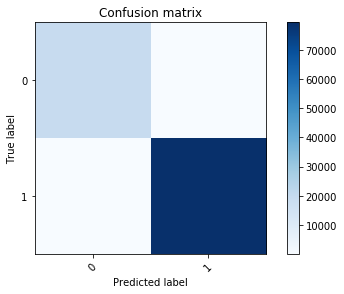

In [67]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_relu, outcome)
plt.show()

In [68]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



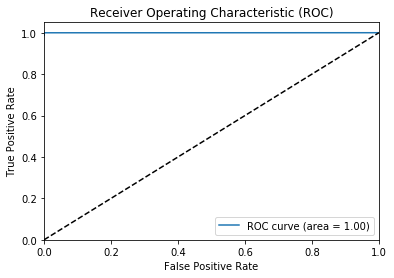

In [69]:
pred_relu = model_reg_relu.predict(x_nn_test)
pred_relu = pred_relu[:,1]
plot_roc(pred_relu,y_eval)

#### Sigmoid, adam, 4 layers  -score_reg_sig_stopping 

In [70]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid_nn.hdf5", verbose=1, save_best_only=True)

In [71]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_sig = Sequential()

    model_reg_sig.add(Dense(120, input_dim=x_nn_train.shape[1], activation='sigmoid'))  
    model_reg_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_reg_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_reg_sig.add(Dense(y.shape[1],activation='softmax')) # Output
    model_reg_sig.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_sig.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_sig.load_weights('./best_weights_sigmoid_nn.hdf5')

0
Train on 395216 samples, validate on 98804 samples
Epoch 1/100
 - 17s - loss: 0.0371 - val_loss: 0.0280

Epoch 00001: val_loss improved from inf to 0.02800, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 2/100
 - 16s - loss: 0.0257 - val_loss: 0.0250

Epoch 00002: val_loss improved from 0.02800 to 0.02496, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 3/100
 - 16s - loss: 0.0250 - val_loss: 0.0258

Epoch 00003: val_loss did not improve from 0.02496
Epoch 4/100
 - 17s - loss: 0.0246 - val_loss: 0.0244

Epoch 00004: val_loss improved from 0.02496 to 0.02438, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 5/100
 - 16s - loss: 0.0243 - val_loss: 0.0238

Epoch 00005: val_loss improved from 0.02438 to 0.02385, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 6/100
 - 16s - loss: 0.0240 - val_loss: 0.0239

Epoch 00006: val_loss did not improve from 0.02385
Epoch 7/100
 - 16s - loss: 0.0238 - val_loss: 0.0236

Epoch 00007: val_loss improved from 0.02385 to 0.02364, sav

In [72]:
# Measure accuracy
pred_nn = model_reg_sig.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [73]:
# Metrics

score_tf_acc_sig = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_sig))

score_tf_precision_sig = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_sig))

score_tf_recall_sig = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_sig))

score_tf_f1_sig = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_sig))

Accuracy score: 0.9949394761345695
Precision score: 0.9950494730768633
Recall score: 0.9949394761345695
F1 score: 0.9949616324501922


In [74]:
cm_sig = confusion_matrix(y_eval, pred_nn)
print(cm_sig)

[[19346    22]
 [  478 78958]]


In [75]:
outcome = encode_text_index(network_nn_df,'outcome')

In [76]:
outcome

array([0, 1])

Plotting confusion matrix


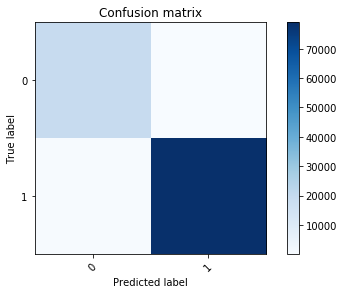

In [77]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_sig, outcome)
plt.show()

In [78]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     19368
          1       1.00      0.99      1.00     79436

avg / total       1.00      0.99      0.99     98804



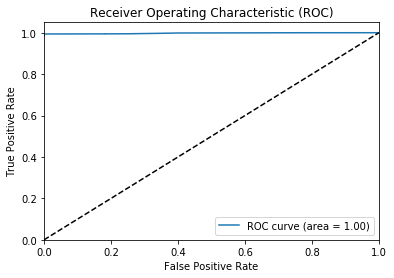

In [79]:
pred_sig = model_reg_sig.predict(x_nn_test)
pred_sig = pred_sig[:,1]
plot_roc(pred_sig,y_eval)

#### Tanh, adam 4 layers score_reg_tanh_stopping

In [80]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh_nn.hdf5", verbose=1, save_best_only=True)


In [81]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_tanh = Sequential()

    model_reg_tanh.add(Dense(120, input_dim=x_nn_train.shape[1], activation='tanh'))  
    model_reg_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_reg_tanh.add(Dense(40, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(y.shape[1],activation='softmax')) # Output
    model_reg_tanh.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_tanh.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_tanh.load_weights('./best_weights_tanh_nn.hdf5')

0
Train on 395216 samples, validate on 98804 samples
Epoch 1/100
 - 20s - loss: 0.0102 - val_loss: 0.0047

Epoch 00001: val_loss improved from inf to 0.00470, saving model to ./best_weights_tanh_nn.hdf5
Epoch 2/100
 - 19s - loss: 0.0048 - val_loss: 0.0043

Epoch 00002: val_loss improved from 0.00470 to 0.00433, saving model to ./best_weights_tanh_nn.hdf5
Epoch 3/100
 - 19s - loss: 0.0044 - val_loss: 0.0036

Epoch 00003: val_loss improved from 0.00433 to 0.00362, saving model to ./best_weights_tanh_nn.hdf5
Epoch 4/100
 - 19s - loss: 0.0036 - val_loss: 0.0051

Epoch 00004: val_loss did not improve from 0.00362
Epoch 5/100
 - 19s - loss: 0.0034 - val_loss: 0.0036

Epoch 00005: val_loss improved from 0.00362 to 0.00359, saving model to ./best_weights_tanh_nn.hdf5
Epoch 6/100
 - 19s - loss: 0.0031 - val_loss: 0.0031

Epoch 00006: val_loss improved from 0.00359 to 0.00307, saving model to ./best_weights_tanh_nn.hdf5
Epoch 00006: early stopping
1
Train on 395216 samples, validate on 98804 sam

In [82]:
# Measure accuracy
pred_nn = model_reg_tanh.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [83]:
# Metrics

score_tf_acc_tanh = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_tanh))

score_tf_precision_tanh = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_tanh))

score_tf_recall_tanh = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_tanh))

score_tf_f1_tanh = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_tanh))

Accuracy score: 0.9992510424679163
Precision score: 0.9992514105204905
Recall score: 0.9992510424679163
F1 score: 0.9992511739686027


In [84]:
cm_tanh = confusion_matrix(y_eval, pred_nn)
print(cm_tanh)

[[19340    28]
 [   46 79390]]


In [85]:
outcome = encode_text_index(network_nn_df,'outcome')

In [86]:
outcome

array([0, 1])

Plotting confusion matrix


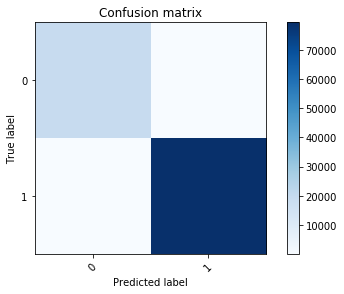

In [87]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_tanh, outcome)
plt.show()

In [88]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



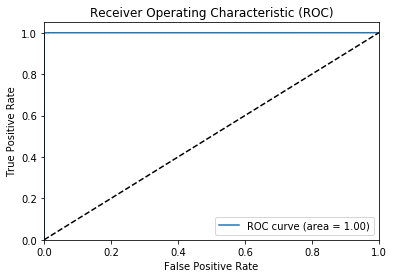

In [89]:
pred_tanh = model_reg_tanh.predict(x_nn_test)
pred_tanh = pred_tanh[:,1]
plot_roc(pred_tanh,y_eval)

## Convolutional Neural Network 

In [90]:
#Split for train and test

x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [91]:
x_cnn_train.shape

(395216, 124)

In [92]:
x_cnn_test.shape

(98804, 124)

In [93]:
y_cnn_train.shape

(395216, 2)

In [94]:
y_cnn_test.shape

(98804, 2)

In [95]:
# we now reshape the x_train and x_test to image form used in CNN 2D
x_cnn_train = x_cnn_train.reshape(x_cnn_train.shape[0], 1, x_cnn_train.shape[1], 1)
x_cnn_test = x_cnn_test.reshape(x_cnn_test.shape[0], 1, x_cnn_test.shape[1], 1)

In [96]:
x_cnn_train[0].shape

(1, 124, 1)

In [97]:
x_cnn_test.shape

(98804, 1, 124, 1)

In [98]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_cnn.hdf5", verbose=1, save_best_only=True)


In [99]:
# CNN 2D

for i in range(4):
    print(i)

    cnn = Sequential()

# Conv2D layer 1
    cnn.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=x_cnn_train[0].shape))
    cnn.add(Conv2D(64, (1, 3), activation='relu'))

    cnn.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn.add(Dropout(0.25))

    cnn.add(Flatten())

    cnn.add(Dense(128, activation='relu'))

    cnn.add(Dropout(0.5))

    cnn.add(Dense(2, activation='softmax'))

    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn.fit(x_cnn_train, y_cnn_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_cnn_test, y_cnn_test))

print('Training finished...Loading the best model') 
print()
cnn.load_weights('./best_weights_cnn.hdf5')

0
Train on 395216 samples, validate on 98804 samples
Epoch 1/10
 - 77s - loss: 0.0126 - acc: 0.9960 - val_loss: 0.0046 - val_acc: 0.9981

Epoch 00001: val_loss improved from inf to 0.00459, saving model to ./best_weights_cnn.hdf5
Epoch 2/10
 - 75s - loss: 0.0041 - acc: 0.9989 - val_loss: 0.0027 - val_acc: 0.9992

Epoch 00002: val_loss improved from 0.00459 to 0.00274, saving model to ./best_weights_cnn.hdf5
Epoch 3/10
 - 77s - loss: 0.0034 - acc: 0.9990 - val_loss: 0.0029 - val_acc: 0.9992

Epoch 00003: val_loss did not improve from 0.00274
Epoch 4/10
 - 78s - loss: 0.0030 - acc: 0.9992 - val_loss: 0.0026 - val_acc: 0.9992

Epoch 00004: val_loss improved from 0.00274 to 0.00256, saving model to ./best_weights_cnn.hdf5
Epoch 5/10
 - 77s - loss: 0.0027 - acc: 0.9993 - val_loss: 0.0020 - val_acc: 0.9994

Epoch 00005: val_loss improved from 0.00256 to 0.00198, saving model to ./best_weights_cnn.hdf5
Epoch 00005: early stopping
1
Train on 395216 samples, validate on 98804 samples
Epoch 1/10

In [100]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 1, 122, 41)        164       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 120, 64)        7936      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 60, 64)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 60, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_157 (Dense)            (None, 128)               491648    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

In [101]:
# Evaluate Accuracy in Keras
score_cnn = cnn.evaluate(x_cnn_test, y_cnn_test, verbose=0)
score_cnn

[0.001976717370160372, 0.9994129792316101]

In [102]:
pred = cnn.predict(x_cnn_test)
pred = np.argmax(pred,axis=1)
pred

array([1, 1, 1, ..., 0, 0, 1])

In [103]:
y_true = np.argmax(y_cnn_test,axis=1)
y_true

array([1, 1, 1, ..., 0, 0, 1])

In [104]:
# Metrics

score_acc_cnn = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score_acc_cnn))

score_precision_cnn = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score_precision_cnn))

score_recall_cnn = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score_recall_cnn))

score_f1_cnn = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score_f1_cnn))

Accuracy score: 0.9994129792316101
Precision score: 0.9994134960875988
Recall score: 0.9994129792316101
F1 score: 0.999413128064702


In [105]:
cm_cnn = confusion_matrix(y_true, pred)
print(cm_cnn)

[[19352    16]
 [   42 79394]]


In [106]:
outcome = encode_text_index(network_nn_df,'outcome')

Plotting confusion matrix


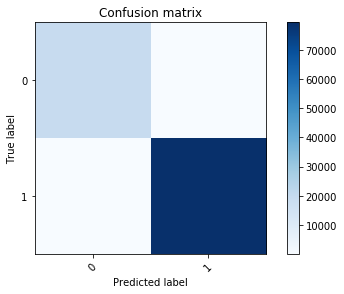

In [107]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn, outcome)
plt.show()

In [108]:
print(classification_report(y_true, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19368
          1       1.00      1.00      1.00     79436

avg / total       1.00      1.00      1.00     98804



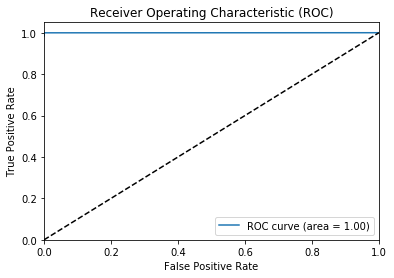

In [109]:
pred_cnn = cnn.predict(x_cnn_test)
pred_cnn = pred_cnn[:,1]
plot_roc(pred_cnn,y_true)

# Additional Features

## Removing Redundancy 

### Data Processing for classical models

In [110]:
#Read network_intrusion_data.csv file and load data into network_df dataframe 
network_af_df= pd.read_csv('network_intrusion_data.csv')

In [111]:
network_af_df.shape

(494020, 42)

In [112]:
#Drop any row with missing values
network_af_df = network_af_df.dropna()

In [113]:
network_af_df.shape

(494020, 42)

In [114]:
#Add column headers to the data in the dataframe
network_af_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [115]:
#Remove redundant rows
network_af_df.drop_duplicates(keep='first', inplace=True)

In [116]:
network_af_df.shape

(145585, 42)

In [117]:
network_af_df.shape

(145585, 42)

In [118]:
#Select colums for feature
features_af_df = network_af_df[['duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
                          
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
                          
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']]

In [119]:
#Label column
label_af_df = network_af_df[['outcome']]

In [120]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(features_af_df,"duration") 
normalize_numeric_minmax(features_af_df,"src_bytes") 
normalize_numeric_minmax(features_af_df,"dst_bytes") 
normalize_numeric_minmax(features_af_df,"wrong_fragment") 
normalize_numeric_minmax(features_af_df,"urgent") 

normalize_numeric_minmax(features_af_df,"hot") 
normalize_numeric_minmax(features_af_df,"num_failed_logins") 
normalize_numeric_minmax(features_af_df,"num_compromised") 
normalize_numeric_minmax(features_af_df,"num_root") 
normalize_numeric_minmax(features_af_df,"num_file_creations") 
normalize_numeric_minmax(features_af_df,"num_shells") 
normalize_numeric_minmax(features_af_df,"num_access_files") 
normalize_numeric_minmax(features_af_df,"num_outbound_cmds") 

normalize_numeric_minmax(features_af_df,"count") 
normalize_numeric_minmax(features_af_df,"srv_count") 
normalize_numeric_minmax(features_af_df,"serror_rate") 
normalize_numeric_minmax(features_af_df,"rerror_rate") 
normalize_numeric_minmax(features_af_df,"srv_rerror_rate")  
normalize_numeric_minmax(features_af_df,"same_srv_rate") 
normalize_numeric_minmax(features_af_df,"diff_srv_rate") 
normalize_numeric_minmax(features_af_df,"srv_diff_host_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_count") 
normalize_numeric_minmax(features_af_df,"dst_host_srv_count") 
normalize_numeric_minmax(features_af_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_serror_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_srv_rerror_rate") 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [121]:
#One hot coding discrete values (9)
encode_text_dummy(features_af_df,"protocol_type") 
encode_text_dummy(features_af_df,"service") 
encode_text_dummy(features_af_df,"flag") 
encode_text_dummy(features_af_df,"land") 

encode_text_dummy(features_af_df,"logged_in") 
encode_text_dummy(features_af_df,"root_shell") 
encode_text_dummy(features_af_df,"su_attempted") 
encode_text_dummy(features_af_df,"is_host_login") 
encode_text_dummy(features_af_df,"is_guest_login") 

In [122]:
#Binary encode the label column
label_af_df['outcome'] = label_af_df['outcome'].apply(encodeLabelBinary)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [123]:
features_af_df.shape

(145585, 124)

In [124]:
#Reduce the data set as the original is too large for classics to run for testing. Remove this section later
#features_af_df = features_af_df[0:10000]
#label_af_df = label_af_df[0:10000]

In [125]:
#Split for training and testing
x_af_train, x_af_test, y_af_train, y_af_test = train_test_split(features_af_df, label_af_df['outcome'] , test_size=0.2, random_state=42)

In [126]:
y_af_test.shape

(29117,)

###  Logistic Regression

In [127]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_af_train, y_af_train)

y_af_pred_logistic = Log_reg_model.predict(x_af_test)

In [128]:
# Metrics

score_acc_log_af = metrics.accuracy_score(y_af_test, y_af_pred_logistic)
print("Accuracy score: {}".format(score_acc_log_af))

score_precision_log_af = metrics.precision_score(y_af_test, y_af_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_precision_log_af))

score_recall_log_af = metrics.recall_score(y_af_test, y_af_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_recall_log_af))

score_f1_log_af = metrics.f1_score(y_af_test, y_af_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_f1_log_af))

Accuracy score: 0.9876360888827832
Precision score: 0.9876555198142505
Recall score: 0.9876360888827832
F1 score: 0.9876232148457863


In [129]:
cm_log_af = confusion_matrix(y_af_test, y_af_pred_logistic)
print(cm_log_af)

[[17477   112]
 [  248 11280]]


In [130]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plotting confusion matrix


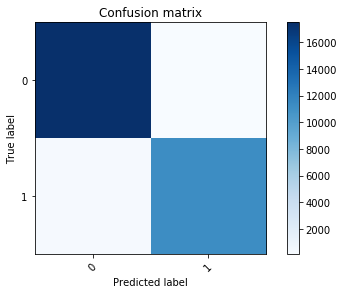

In [131]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_log_af, outcome)
plt.show()

In [132]:
print(classification_report(y_af_test, y_af_pred_logistic))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     17589
          1       0.99      0.98      0.98     11528

avg / total       0.99      0.99      0.99     29117



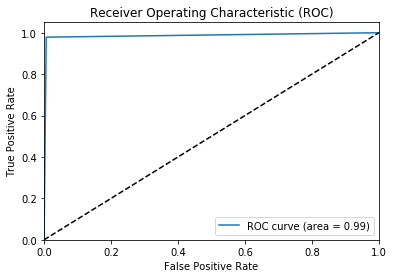

In [133]:
pred_log_af = Log_reg_model.predict(x_af_test)
pred_log_af = pred_log_af[:]
plot_roc(pred_log_af,y_af_test)

### KNN 

In [134]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(x_af_train, y_af_train) 

y_af_pred_knn = knn.predict(x_af_test)

In [135]:
# Metrics
from sklearn import metrics

score_af_knn_acc_af = metrics.accuracy_score(y_af_test, y_af_pred_knn)
print("Accuracy score: {}".format(score_af_knn_acc_af))

score_af_knn_precision_af = metrics.precision_score(y_af_test, y_af_pred_knn, average= "weighted")
print("Precision score: {}".format(score_af_knn_precision_af))

score_af_knn_recall_af = metrics.recall_score(y_af_test, y_af_pred_knn, average= "weighted")
print("Recall score: {}".format(score_af_knn_recall_af))

score_af_knn_f1_af = metrics.f1_score(y_af_test, y_af_pred_knn, average= "weighted")
print("F1 score: {}".format(score_af_knn_f1_af))

Accuracy score: 0.9983514785177044
Precision score: 0.9983514386974491
Recall score: 0.9983514785177044
F1 score: 0.9983513798219226


In [136]:
cm_knn_af = confusion_matrix(y_af_test, y_af_pred_knn)
print(cm_knn_af)

[[17569    20]
 [   28 11500]]


In [137]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plotting confusion matrix


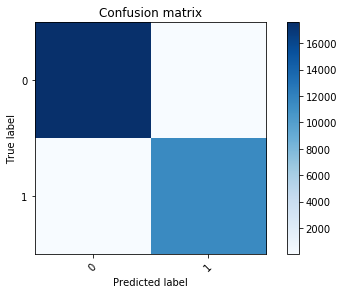

In [138]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_knn_af, outcome)
plt.show()

In [139]:
print(classification_report(y_af_test, y_af_pred_knn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



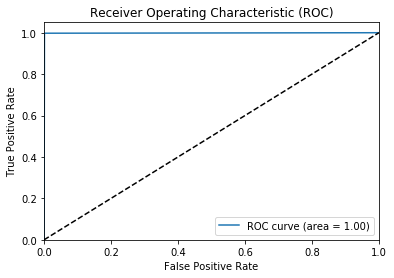

In [140]:
pred_knn_af = knn.predict(x_af_test)
pred_knn_af = pred_knn_af[:]
plot_roc(pred_knn_af,y_af_test)

### SVM 

In [141]:
# SVM
from sklearn.svm import SVC

svm_model = SVC(kernel="linear")

svm_model.fit(x_af_train, y_af_train)

y_af_pred_svm = svm_model.predict(x_af_test)

In [142]:
# Metrics

score_svm_acc_af = metrics.accuracy_score(y_af_test, y_af_pred_svm)
print("Accuracy score: {}".format(score_svm_acc_af))

score_svm_precision_af = metrics.precision_score(y_af_test, y_af_pred_svm, average= "weighted")
print("Precision score: {}".format(score_svm_precision_af))

score_svm_recall_af = metrics.recall_score(y_af_test, y_af_pred_svm, average= "weighted")
print("Recall score: {}".format(score_svm_recall_af))

score_svm_f1_af = metrics.f1_score(y_af_test, y_af_pred_svm, average= "weighted")
print("F1 score: {}".format(score_svm_f1_af))

Accuracy score: 0.9922038671566439
Precision score: 0.9922025866386067
Recall score: 0.9922038671566439
F1 score: 0.9922020510243128


In [143]:
cm_svm_af = confusion_matrix(y_af_test, y_af_pred_svm)
print(cm_svm_af)

[[17491    98]
 [  129 11399]]


In [144]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plotting confusion matrix


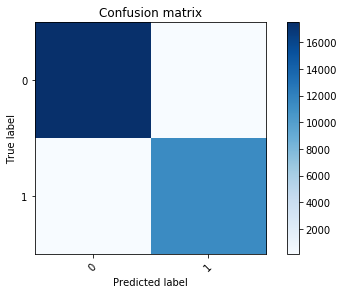

In [145]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_svm_af, outcome)
plt.show()

In [146]:
print(classification_report(y_af_test, y_af_pred_svm))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     17589
          1       0.99      0.99      0.99     11528

avg / total       0.99      0.99      0.99     29117



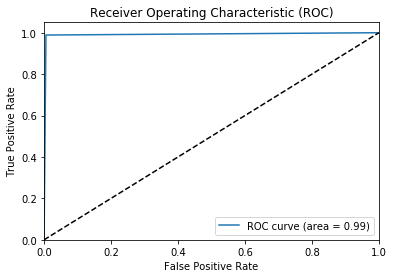

In [147]:
pred_svm_af = svm_model.predict(x_af_test)
pred_svm_af = pred_svm_af[:]
plot_roc(pred_svm_af,y_af_test)

### Gaussian Naive Bayes 

In [148]:
#GNB
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()

gnb_model.fit(x_af_train, y_af_train)

y_af_pred_gnb = gnb_model.predict(x_af_test)

In [149]:
# Metrics

score_gnb_acc_af = metrics.accuracy_score(y_af_test, y_af_pred_gnb)
print("Accuracy score: {}".format(score_gnb_acc_af))

score_gnb_precision_af = metrics.precision_score(y_af_test, y_af_pred_gnb, average= "weighted")
print("Precision score: {}".format(score_gnb_precision_af))

score_gnb_recall_af = metrics.recall_score(y_af_test, y_af_pred_gnb, average= "weighted")
print("Recall score: {}".format(score_gnb_recall_af))

score_gnb_f1_af = metrics.f1_score(y_af_test, y_af_pred_gnb, average= "weighted")
print("F1 score: {}".format(score_gnb_f1_af))

Accuracy score: 0.918295154033726
Precision score: 0.926633232685079
Recall score: 0.918295154033726
F1 score: 0.9163503763232373


In [150]:
cm_gnb_af = confusion_matrix(y_af_test, y_af_pred_gnb)
print(cm_gnb_af)

[[17517    72]
 [ 2307  9221]]


In [151]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plotting confusion matrix


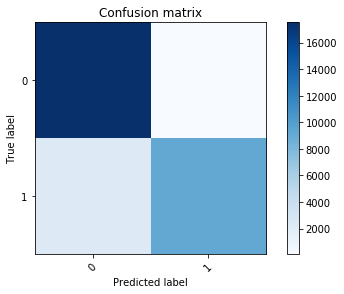

In [152]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_gnb_af, outcome)
plt.show()

In [153]:
print(classification_report(y_af_test, y_af_pred_gnb))

             precision    recall  f1-score   support

          0       0.88      1.00      0.94     17589
          1       0.99      0.80      0.89     11528

avg / total       0.93      0.92      0.92     29117



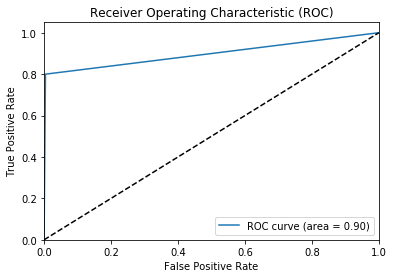

In [155]:
pred_gnb_af = gnb_model.predict(x_af_test)
pred_gnb_af = pred_gnb_af[:]
plot_roc(pred_gnb_af,y_af_test)

### Data processing for NN and CNN 

In [156]:
network_rr_df= pd.read_csv('network_intrusion_data.csv', delimiter =",")

In [157]:
#Add column headers to the data in the dataframe
network_rr_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [158]:
network_rr_df.shape

(494020, 42)

In [159]:
network_rr_df.drop_duplicates(keep='first', inplace=True)

In [160]:
network_rr_df.shape

(145585, 42)

In [161]:
network_rr_df.shape

(145585, 42)

In [162]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(network_rr_df,"duration") 
normalize_numeric_minmax(network_rr_df,"src_bytes") 
normalize_numeric_minmax(network_rr_df,"dst_bytes") 
normalize_numeric_minmax(network_rr_df,"wrong_fragment") 
normalize_numeric_minmax(network_rr_df,"urgent") 

normalize_numeric_minmax(network_rr_df,"hot") 
normalize_numeric_minmax(network_rr_df,"num_failed_logins") 
normalize_numeric_minmax(network_rr_df,"num_compromised") 
normalize_numeric_minmax(network_rr_df,"num_root") 
normalize_numeric_minmax(network_rr_df,"num_file_creations") 
normalize_numeric_minmax(network_rr_df,"num_shells") 
normalize_numeric_minmax(network_rr_df,"num_access_files") 
normalize_numeric_minmax(network_rr_df,"num_outbound_cmds") 

normalize_numeric_minmax(network_rr_df,"count") 
normalize_numeric_minmax(network_rr_df,"srv_count") 
normalize_numeric_minmax(network_rr_df,"serror_rate") 
normalize_numeric_minmax(network_rr_df,"rerror_rate") 
normalize_numeric_minmax(network_rr_df,"srv_rerror_rate")  
normalize_numeric_minmax(network_rr_df,"same_srv_rate") 
normalize_numeric_minmax(network_rr_df,"diff_srv_rate") 
normalize_numeric_minmax(network_rr_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_count") 
normalize_numeric_minmax(network_rr_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_rr_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_srv_rerror_rate") 

In [163]:
#One hot coding discrete values (9)
encode_text_dummy(network_rr_df,"protocol_type") 
encode_text_dummy(network_rr_df,"service") 
encode_text_dummy(network_rr_df,"flag") 
encode_text_dummy(network_rr_df,"land") 
encode_text_dummy(network_rr_df,"logged_in") 
encode_text_dummy(network_rr_df,"root_shell") 
encode_text_dummy(network_rr_df,"su_attempted") 
encode_text_dummy(network_rr_df,"is_host_login") 
encode_text_dummy(network_rr_df,"is_guest_login") 

In [164]:
network_rr_df.shape

(145585, 125)

In [165]:
#network_rr_df= network_rr_df[0:40000]

In [166]:
network_rr_df['outcome'] = network_rr_df['outcome'].apply(encodeLabelBinary)


In [167]:
network_rr_df.shape

(145585, 125)

In [168]:
x_af,y_af=to_xy(network_rr_df,"outcome")

In [169]:
x_af.shape

(145585, 124)

In [170]:
y_af.shape

(145585, 2)

### Fully connected Neural Network 

In [171]:
#Split for train and test
x_nn_train, x_nn_test, y_nn_train, y_nn_test = train_test_split(x_af,y_af, test_size=0.2, random_state=42)

#### ReLU, adam, 4 layers, early stopping and Model checkpoint  - score_4l

In [172]:
# set up checkpointer
checkpointer_relu_af = ModelCheckpoint(filepath="./best_weights_relu_4l_nn_af.hdf5", verbose=1, save_best_only=True)

In [173]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()
    model_reg_relu.add(Dense(10, input_dim=x_nn_train.shape[1], activation='relu'))
    model_reg_relu.add(Dense(50, activation='relu'))
    model_reg_relu.add(Dense(10, activation='relu'))
    model_reg_relu.add(Dense(1))
    model_reg_relu.add(Dense(y_af.shape[1],activation='softmax'))
    model_reg_relu.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_relu_af ],verbose=2,epochs=1000)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_4l_nn_af.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/1000
 - 9s - loss: 0.0375 - val_loss: 0.0159

Epoch 00001: val_loss improved from inf to 0.01594, saving model to ./best_weights_relu_4l_nn_af.hdf5
Epoch 2/1000
 - 8s - loss: 0.0129 - val_loss: 0.0085

Epoch 00002: val_loss improved from 0.01594 to 0.00848, saving model to ./best_weights_relu_4l_nn_af.hdf5
Epoch 3/1000
 - 8s - loss: 0.0093 - val_loss: 0.0072

Epoch 00003: val_loss improved from 0.00848 to 0.00723, saving model to ./best_weights_relu_4l_nn_af.hdf5
Epoch 4/1000
 - 8s - loss: 0.0080 - val_loss: 0.0066

Epoch 00004: val_loss improved from 0.00723 to 0.00664, saving model to ./best_weights_relu_4l_nn_af.hdf5
Epoch 5/1000
 - 8s - loss: 0.0075 - val_loss: 0.0072

Epoch 00005: val_loss did not improve from 0.00664
Epoch 6/1000
 - 7s - loss: 0.0072 - val_loss: 0.0061

Epoch 00006: val_loss improved from 0.00664 to 0.00605, saving model to ./best_weights_relu_4l_nn_af.hdf5
Epoch 7/1000
 - 7s - loss: 0.0065 - val_loss: 


Epoch 00008: val_loss did not improve from 0.00509
Epoch 9/1000
 - 7s - loss: 0.0071 - val_loss: 0.0071

Epoch 00009: val_loss did not improve from 0.00509
Epoch 10/1000
 - 7s - loss: 0.0073 - val_loss: 0.0073

Epoch 00010: val_loss did not improve from 0.00509
Epoch 11/1000
 - 7s - loss: 0.0067 - val_loss: 0.0077

Epoch 00011: val_loss did not improve from 0.00509
Epoch 12/1000
 - 7s - loss: 0.0066 - val_loss: 0.0078

Epoch 00012: val_loss did not improve from 0.00509
Epoch 13/1000
 - 7s - loss: 0.0062 - val_loss: 0.0073

Epoch 00013: val_loss did not improve from 0.00509
Epoch 00013: early stopping
6
Train on 116468 samples, validate on 29117 samples
Epoch 1/1000
 - 9s - loss: 0.0546 - val_loss: 0.0231

Epoch 00001: val_loss did not improve from 0.00509
Epoch 2/1000
 - 7s - loss: 0.0194 - val_loss: 0.0147

Epoch 00002: val_loss did not improve from 0.00509
Epoch 3/1000
 - 7s - loss: 0.0130 - val_loss: 0.0109

Epoch 00003: val_loss did not improve from 0.00509
Epoch 4/1000
 - 7s - lo

In [174]:
# Measure accuracy
pred_nn = model_reg_relu.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [175]:
# Metrics

score_tf_acc_relu_af = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_relu_af))

score_tf_precision_relu_af = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_relu_af))

score_tf_recall_relu_af = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_relu_af))

score_tf_f1_relu_af = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_relu_af))

Accuracy score: 0.9985231995054435
Precision score: 0.9985233281256618
Recall score: 0.9985231995054435
F1 score: 0.9985230557019816


In [176]:
cm_relu_af = confusion_matrix(y_eval, pred_nn)
print(cm_relu_af)

[[17574    15]
 [   28 11500]]


In [177]:
outcome = encode_text_index(network_rr_df,'outcome')

In [178]:
outcome

array([0, 1])

Plotting confusion matrix


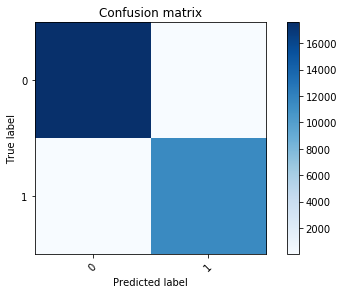

In [179]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_relu_af, outcome)
plt.show()

In [180]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



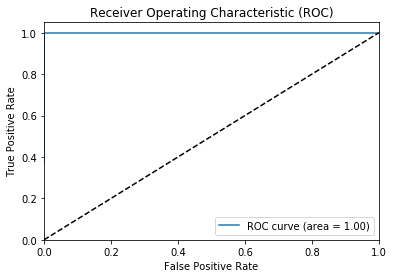

In [181]:
pred_relu_af = model_reg_relu.predict(x_nn_test)
pred_relu_af = pred_relu_af[:,1]
plot_roc(pred_relu_af,y_eval)

#### Sigmoid, adam, 4 layers  -score_reg_sig_stopping 

In [182]:
# set up checkpointer
checkpointer_sigmoid_af = ModelCheckpoint(filepath="./best_weights_sigmoid_nn_af.hdf5", verbose=1, save_best_only=True)

In [183]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_sig = Sequential()

    model_reg_sig.add(Dense(120, input_dim=x_nn_train.shape[1], activation='sigmoid'))  
    model_reg_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_reg_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_reg_sig.add(Dense(y_af.shape[1],activation='softmax')) # Output
    model_reg_sig.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_sig.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_sigmoid_af],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_sig.load_weights('./best_weights_sigmoid_nn_af.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 8s - loss: 0.6723 - val_loss: 0.6680

Epoch 00001: val_loss improved from inf to 0.66803, saving model to ./best_weights_sigmoid_nn_af.hdf5
Epoch 2/100
 - 7s - loss: 0.6623 - val_loss: 0.6507

Epoch 00002: val_loss improved from 0.66803 to 0.65069, saving model to ./best_weights_sigmoid_nn_af.hdf5
Epoch 3/100
 - 7s - loss: 0.5110 - val_loss: 0.1829

Epoch 00003: val_loss improved from 0.65069 to 0.18287, saving model to ./best_weights_sigmoid_nn_af.hdf5
Epoch 4/100
 - 7s - loss: 0.1293 - val_loss: 0.1123

Epoch 00004: val_loss improved from 0.18287 to 0.11234, saving model to ./best_weights_sigmoid_nn_af.hdf5
Epoch 5/100
 - 7s - loss: 0.1079 - val_loss: 0.1002

Epoch 00005: val_loss improved from 0.11234 to 0.10017, saving model to ./best_weights_sigmoid_nn_af.hdf5
Epoch 6/100
 - 7s - loss: 0.0966 - val_loss: 0.0907

Epoch 00006: val_loss improved from 0.10017 to 0.09072, saving model to ./best_weights_sigmoid_nn_af.hd

 - 7s - loss: 0.1026 - val_loss: 0.0940

Epoch 00005: val_loss did not improve from 0.03726
Epoch 6/100
 - 7s - loss: 0.0896 - val_loss: 0.0815

Epoch 00006: val_loss did not improve from 0.03726
Epoch 7/100
 - 7s - loss: 0.0786 - val_loss: 0.0724

Epoch 00007: val_loss did not improve from 0.03726
Epoch 8/100
 - 7s - loss: 0.0706 - val_loss: 0.0660

Epoch 00008: val_loss did not improve from 0.03726
Epoch 9/100
 - 7s - loss: 0.0651 - val_loss: 0.0623

Epoch 00009: val_loss did not improve from 0.03726
Epoch 10/100
 - 7s - loss: 0.0614 - val_loss: 0.0583

Epoch 00010: val_loss did not improve from 0.03726
Epoch 11/100
 - 7s - loss: 0.0585 - val_loss: 0.0558

Epoch 00011: val_loss did not improve from 0.03726
Epoch 12/100
 - 7s - loss: 0.0561 - val_loss: 0.0540

Epoch 00012: val_loss did not improve from 0.03726
Epoch 13/100
 - 7s - loss: 0.0538 - val_loss: 0.0514

Epoch 00013: val_loss did not improve from 0.03726
Epoch 14/100
 - 7s - loss: 0.0518 - val_loss: 0.0497

Epoch 00014: val_l

 - 7s - loss: 0.0403 - val_loss: 0.0390

Epoch 00027: val_loss did not improve from 0.03726
Epoch 28/100
 - 7s - loss: 0.0399 - val_loss: 0.0386

Epoch 00028: val_loss did not improve from 0.03726
Epoch 29/100
 - 7s - loss: 0.0395 - val_loss: 0.0390

Epoch 00029: val_loss did not improve from 0.03726
Epoch 30/100
 - 7s - loss: 0.0392 - val_loss: 0.0384

Epoch 00030: val_loss did not improve from 0.03726
Epoch 00030: early stopping
5
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 9s - loss: 0.6715 - val_loss: 0.6701

Epoch 00001: val_loss did not improve from 0.03726
Epoch 2/100
 - 7s - loss: 0.6694 - val_loss: 0.6678

Epoch 00002: val_loss did not improve from 0.03726
Epoch 3/100
 - 7s - loss: 0.6624 - val_loss: 0.6517

Epoch 00003: val_loss did not improve from 0.03726
Epoch 4/100
 - 7s - loss: 0.5290 - val_loss: 0.2095

Epoch 00004: val_loss did not improve from 0.03726
Epoch 5/100
 - 7s - loss: 0.1332 - val_loss: 0.1106

Epoch 00005: val_loss did not improve from 

 - 7s - loss: 0.0480 - val_loss: 0.0466

Epoch 00017: val_loss did not improve from 0.03726
Epoch 18/100
 - 7s - loss: 0.0467 - val_loss: 0.0455

Epoch 00018: val_loss did not improve from 0.03726
Epoch 19/100
 - 7s - loss: 0.0456 - val_loss: 0.0441

Epoch 00019: val_loss did not improve from 0.03726
Epoch 20/100
 - 7s - loss: 0.0445 - val_loss: 0.0429

Epoch 00020: val_loss did not improve from 0.03726
Epoch 21/100
 - 7s - loss: 0.0438 - val_loss: 0.0425

Epoch 00021: val_loss did not improve from 0.03726
Epoch 22/100
 - 7s - loss: 0.0431 - val_loss: 0.0416

Epoch 00022: val_loss did not improve from 0.03726
Epoch 23/100
 - 7s - loss: 0.0425 - val_loss: 0.0414

Epoch 00023: val_loss did not improve from 0.03726
Epoch 24/100
 - 7s - loss: 0.0420 - val_loss: 0.0416

Epoch 00024: val_loss did not improve from 0.03726
Epoch 25/100
 - 7s - loss: 0.0415 - val_loss: 0.0399

Epoch 00025: val_loss did not improve from 0.03726
Epoch 26/100
 - 7s - loss: 0.0410 - val_loss: 0.0401

Epoch 00026: v

In [184]:
# Measure accuracy
pred_nn = model_reg_sig.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [185]:
# Metrics

score_tf_acc_sig_af = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_sig_af))

score_tf_precision_sig_af = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_sig_af))

score_tf_recall_sig_af = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_sig_af))

score_tf_f1_sig_af = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_sig_af))

Accuracy score: 0.986331009375966
Precision score: 0.986336941032662
Recall score: 0.986331009375966
F1 score: 0.9863197626089032


In [186]:
cm_sig_af = confusion_matrix(y_eval, pred_nn)
print(cm_sig_af)

[[17444   145]
 [  253 11275]]


In [187]:
outcome = encode_text_index(network_rr_df,'outcome')

In [188]:
outcome

array([0, 1])

Plotting confusion matrix


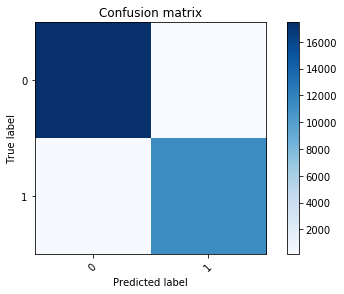

In [189]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_sig_af, outcome)
plt.show()

In [190]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     17589
          1       0.99      0.98      0.98     11528

avg / total       0.99      0.99      0.99     29117



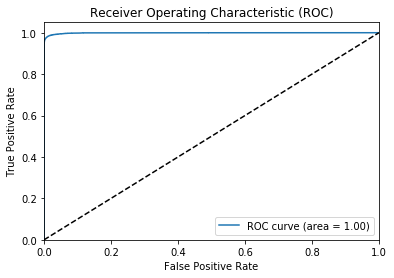

In [191]:
pred_sig_af = model_reg_sig.predict(x_nn_test)
pred_sig_af = pred_sig_af[:,1]
plot_roc(pred_sig_af,y_eval)

#### Tanh, adam 4 layers score_reg_tanh_stopping

In [192]:
# set up checkpointer
checkpointer_tanh_af = ModelCheckpoint(filepath="./best_weights_tanh_nn_af.hdf5", verbose=1, save_best_only=True)


In [193]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_tanh = Sequential()

    model_reg_tanh.add(Dense(120, input_dim=x_nn_train.shape[1], activation='tanh'))  
    model_reg_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_reg_tanh.add(Dense(40, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(y_af.shape[1],activation='softmax')) # Output
    model_reg_tanh.compile(loss='categorical_crossentropy', optimizer='adagrad')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_tanh.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_tanh_af],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_tanh.load_weights('./best_weights_tanh_nn_af.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 10s - loss: 0.0348 - val_loss: 0.0196

Epoch 00001: val_loss improved from inf to 0.01955, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 2/100
 - 7s - loss: 0.0158 - val_loss: 0.0127

Epoch 00002: val_loss improved from 0.01955 to 0.01267, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 3/100
 - 7s - loss: 0.0110 - val_loss: 0.0098

Epoch 00003: val_loss improved from 0.01267 to 0.00980, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 4/100
 - 7s - loss: 0.0095 - val_loss: 0.0093

Epoch 00004: val_loss improved from 0.00980 to 0.00925, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 5/100
 - 7s - loss: 0.0087 - val_loss: 0.0107

Epoch 00005: val_loss did not improve from 0.00925
Epoch 6/100
 - 7s - loss: 0.0082 - val_loss: 0.0085

Epoch 00006: val_loss improved from 0.00925 to 0.00855, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 7/100
 - 7s - loss: 0.0078 - val_loss: 0.0085

Epoch 00007: 

 - 8s - loss: 0.0076 - val_loss: 0.0075

Epoch 00009: val_loss did not improve from 0.00640
Epoch 00009: early stopping
7
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 10s - loss: 0.0335 - val_loss: 0.0185

Epoch 00001: val_loss did not improve from 0.00640
Epoch 2/100
 - 8s - loss: 0.0152 - val_loss: 0.0118

Epoch 00002: val_loss did not improve from 0.00640
Epoch 3/100
 - 8s - loss: 0.0111 - val_loss: 0.0104

Epoch 00003: val_loss did not improve from 0.00640
Epoch 4/100
 - 8s - loss: 0.0097 - val_loss: 0.0095

Epoch 00004: val_loss did not improve from 0.00640
Epoch 5/100
 - 8s - loss: 0.0088 - val_loss: 0.0110

Epoch 00005: val_loss did not improve from 0.00640
Epoch 6/100
 - 8s - loss: 0.0085 - val_loss: 0.0082

Epoch 00006: val_loss did not improve from 0.00640
Epoch 7/100
 - 8s - loss: 0.0078 - val_loss: 0.0084

Epoch 00007: val_loss did not improve from 0.00640
Epoch 8/100
 - 8s - loss: 0.0076 - val_loss: 0.0080

Epoch 00008: val_loss did not improve from 0.

In [194]:
# Measure accuracy
pred_nn = model_reg_tanh.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [195]:
# Metrics

score_tf_acc_tanh_af = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_tanh_af))

score_tf_precision_tanh_af = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_tanh_af))

score_tf_recall_tanh_af = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_tanh_af))

score_tf_f1_tanh_af = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_tanh_af))

Accuracy score: 0.9980767249373218
Precision score: 0.9980766831171078
Recall score: 0.9980767249373218
F1 score: 0.998076580954231


In [196]:
cm_tanh_af = confusion_matrix(y_eval, pred_nn)
print(cm_tanh_af)

[[17566    23]
 [   33 11495]]


In [197]:
outcome = encode_text_index(network_rr_df,'outcome')

In [198]:
outcome

array([0, 1])

Plotting confusion matrix


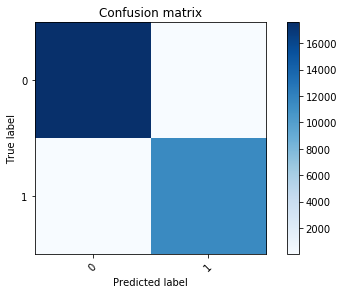

In [199]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_tanh_af, outcome)
plt.show()

In [200]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



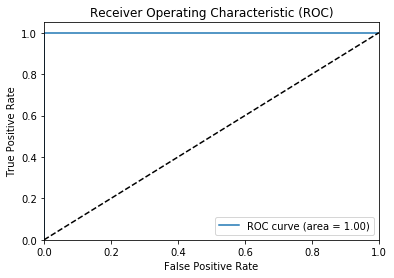

In [201]:
pred_tanh_af = model_reg_tanh.predict(x_nn_test)
pred_tanh_af = pred_tanh_af[:,1]
plot_roc(pred_tanh_af,y_eval)

### Convolutional Neural Network 

In [202]:
x_cnn_train_af, x_cnn_test_af, y_cnn_train_af, y_cnn_test_af = train_test_split(x_af,y_af, test_size=0.2, random_state=42)

In [203]:
x_cnn_train_af.shape

(116468, 124)

In [204]:
y_cnn_train_af.shape

(116468, 2)

In [205]:
# we now reshape the x_train and x_test to image form used in CNN 2D
x_cnn_train_af = x_cnn_train_af.reshape(x_cnn_train_af.shape[0], 1, x_cnn_train_af.shape[1], 1)
x_cnn_test_af = x_cnn_test_af.reshape(x_cnn_test_af.shape[0], 1, x_cnn_test_af.shape[1], 1)

In [206]:
x_cnn_train_af[0].shape

(1, 124, 1)

In [207]:
checkpointer_cnn_af = ModelCheckpoint(filepath="./best_weights_cnn_af.hdf5", verbose=1, save_best_only=True)


In [208]:
# CNN 2D

for i in range(4):
    print(i)

    cnn_af = Sequential()

# Conv2D layer 1
    cnn_af.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=x_cnn_train_af[0].shape))
    cnn_af.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_af.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_af.add(Dropout(0.25))

    cnn_af.add(Flatten())

    cnn_af.add(Dense(164, activation='relu'))

    cnn_af.add(Dropout(0.5))

    cnn_af.add(Dense(2, activation='softmax'))

    cnn_af.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn_af.fit(x_cnn_train_af, y_cnn_train_af, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn_af], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_cnn_test_af, y_cnn_test_af))

print('Training finished...Loading the best model') 
print()
cnn_af.load_weights('./best_weights_cnn_af.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 35s - loss: 0.0364 - acc: 0.9890 - val_loss: 0.0100 - val_acc: 0.9977

Epoch 00001: val_loss improved from inf to 0.01001, saving model to ./best_weights_cnn_af.hdf5
Epoch 2/10
 - 32s - loss: 0.0117 - acc: 0.9966 - val_loss: 0.0085 - val_acc: 0.9969

Epoch 00002: val_loss improved from 0.01001 to 0.00845, saving model to ./best_weights_cnn_af.hdf5
Epoch 3/10
 - 32s - loss: 0.0096 - acc: 0.9973 - val_loss: 0.0056 - val_acc: 0.9983

Epoch 00003: val_loss improved from 0.00845 to 0.00560, saving model to ./best_weights_cnn_af.hdf5
Epoch 4/10
 - 32s - loss: 0.0084 - acc: 0.9975 - val_loss: 0.0056 - val_acc: 0.9984

Epoch 00004: val_loss did not improve from 0.00560
Epoch 5/10
 - 32s - loss: 0.0077 - acc: 0.9979 - val_loss: 0.0056 - val_acc: 0.9985

Epoch 00005: val_loss improved from 0.00560 to 0.00557, saving model to ./best_weights_cnn_af.hdf5
Epoch 6/10
 - 32s - loss: 0.0067 - acc: 0.9981 - val_loss: 0.0043 - val_acc: 0.

In [209]:
cnn_af.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 1, 122, 41)        164       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 120, 82)        10168     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 60, 82)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 60, 82)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4920)              0         
_________________________________________________________________
dense_315 (Dense)            (None, 164)               807044    
_________________________________________________________________
dropout_16 (Dropout)         (None, 164)               0         
__________

In [210]:
# Evaluate Accuracy in Keras
score_cnn_af = cnn_af.evaluate(x_cnn_test, y_cnn_test, verbose=0)
score_cnn_af

[0.0014320696301395905, 0.9995749159953038]

In [211]:
pred_cnn_af = cnn_af.predict(x_cnn_test_af)
pred_cnn_af = np.argmax(pred_cnn_af,axis=1)
pred_cnn_af

array([0, 1, 0, ..., 1, 1, 1])

In [212]:
y_true_cnn_af = np.argmax(y_cnn_test_af,axis=1)
y_true_cnn_af

array([0, 1, 0, ..., 1, 1, 1])

In [213]:
# Metrics

score_acc_cnn_af = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score_acc_cnn_af))

score_precision_cnn_af = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score_precision_cnn_af))

score_recall_cnn_af = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score_recall_cnn_af))

score_f1_cnn_af = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score_f1_cnn_af))

Accuracy score: 0.9994129792316101
Precision score: 0.9994134960875988
Recall score: 0.9994129792316101
F1 score: 0.999413128064702


In [214]:
cm_cnn_af = confusion_matrix(y_true_cnn_af, pred_cnn_af)
print(cm_cnn_af)

[[17576    13]
 [   22 11506]]


In [215]:
outcome = encode_text_index(network_rr_df,'outcome')

Plotting confusion matrix


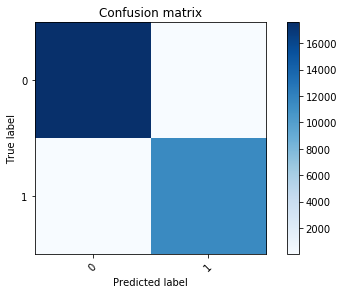

In [216]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn_af, outcome)
plt.show()

In [217]:
print(classification_report(y_true_cnn_af, pred_cnn_af))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



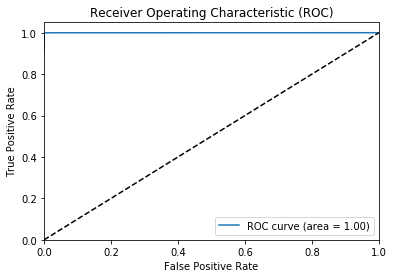

In [218]:
pred_cnn_af = cnn_af.predict(x_cnn_test_af)
pred_cnn_af = pred_cnn_af[:,1]
plot_roc(pred_cnn_af,y_true_cnn_af)

## Feature Importance Analysis 

### Feature importance and selection

In [219]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

extraTreeClassifier = ExtraTreesClassifier()
extraTreeClassifier.fit(features_af_df, label_af_df['outcome'])

# display the relative importance of each attribute

print(extraTreeClassifier.feature_importances_)

[1.50847909e-03 1.22698686e-02 1.38976835e-03 1.07959658e-02
 2.40653321e-05 1.31026817e-02 4.93745850e-05 3.92006961e-03
 1.41249704e-04 9.28284995e-05 1.75609819e-05 4.82924140e-05
 0.00000000e+00 1.36224717e-01 2.92291179e-03 6.45901761e-03
 4.39894043e-03 1.04951452e-02 1.01661410e-02 1.48657376e-02
 3.55600517e-03 3.36759600e-03 1.42591821e-02 8.03433932e-03
 4.15309239e-02 7.85506375e-03 1.19805866e-02 5.40772034e-03
 2.30921893e-03 7.56262673e-02 2.84168398e-03 5.80608682e-03
 6.72779259e-03 1.49748404e-03 8.17898896e-03 1.48858401e-04
 8.02947913e-06 0.00000000e+00 7.81992964e-05 0.00000000e+00
 0.00000000e+00 5.14970136e-05 0.00000000e+00 0.00000000e+00
 8.95966532e-08 4.59243752e-05 1.14017344e-02 0.00000000e+00
 2.29064677e-03 1.34569125e-03 4.45700999e-06 0.00000000e+00
 1.46677678e-04 8.01678631e-04 1.59065861e-03 1.67679147e-05
 1.41742239e-13 9.60838126e-03 0.00000000e+00 7.21600362e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.17103683e-06 1.385451

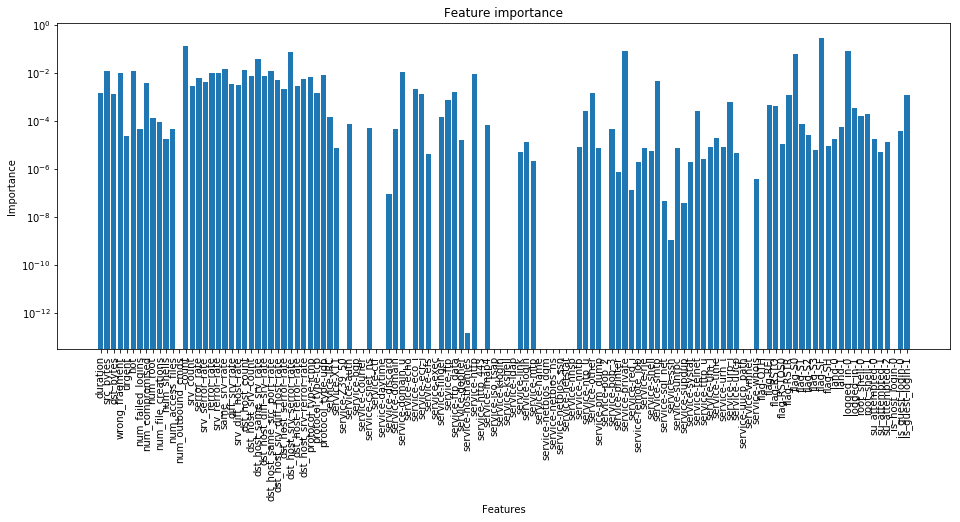

In [220]:
feature_importance = extraTreeClassifier.feature_importances_
plt.figure(figsize=(16, 6))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), features_af_df, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [221]:
##Choose only relevant features

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(extraTreeClassifier, prefit=True)
X_new = model.transform(features_af_df)
feature_idx = model.get_support()
feature_name = features_af_df.columns[feature_idx]

In [222]:
feature_name

Index(['src_bytes', 'wrong_fragment', 'hot', 'count', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'dst_host_count',
       'dst_host_same_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_serror_rate', 'protocol_type-udp', 'service-domain_u',
       'service-http', 'service-private', 'flag-S0', 'flag-SF', 'logged_in-0'],
      dtype='object')

In [223]:
#Train test split for feature analysis. Redundancy is removed from data here
x_adf_train, x_adf_test, y_adf_train, y_adf_test = train_test_split(X_new, label_af_df['outcome'] , test_size=0.2, random_state=42)

In [332]:
x_adf_train.shape

(116468, 18)

In [224]:
y_adf_test.shape

(29117,)

###  Logistic Regression

In [225]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_adf_train, y_adf_train)

y_adf_pred_logistic = Log_reg_model.predict(x_adf_test)

In [226]:
# Metrics

score_adf_logistic_acc = metrics.accuracy_score(y_adf_test, y_adf_pred_logistic)
print("Accuracy score: {}".format(score_adf_logistic_acc))

score_adf_logistic_precision = metrics.precision_score(y_adf_test, y_adf_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_adf_logistic_precision))

score_adf_logistic_recall = metrics.recall_score(y_adf_test, y_adf_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_adf_logistic_recall))

score_adf_logistic_f1 = metrics.f1_score(y_adf_test, y_adf_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_adf_logistic_f1))

Accuracy score: 0.9837208503623313
Precision score: 0.9837784158032781
Recall score: 0.9837208503623313
F1 score: 0.9836938095343001


In [227]:
cm_log_fa = confusion_matrix(y_adf_test, y_adf_pred_logistic)
print(cm_log_fa)

[[17459   130]
 [  344 11184]]


In [228]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plotting confusion matrix


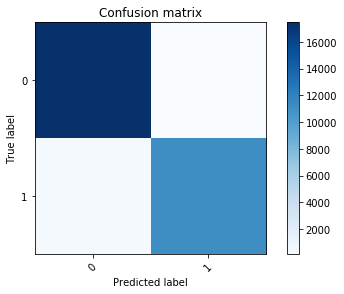

In [229]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_log_fa, outcome)
plt.show()

In [230]:
print(classification_report(y_adf_test, y_adf_pred_logistic))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99     17589
          1       0.99      0.97      0.98     11528

avg / total       0.98      0.98      0.98     29117



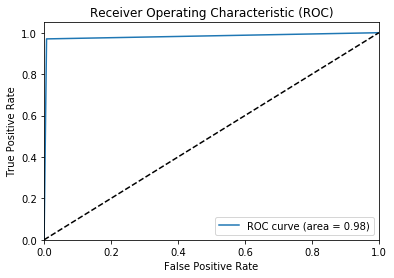

In [231]:
pred_log_fa = Log_reg_model.predict(x_adf_test)
pred_log_fa = pred_log_fa[:]
plot_roc(pred_log_fa,y_adf_test)

### KNN

In [232]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(x_adf_train, y_adf_train) 

y_adf_pred_knn = knn.predict(x_adf_test)

In [233]:
# Metrics
from sklearn import metrics

score_adf_knn_acc = metrics.accuracy_score(y_adf_test, y_adf_pred_knn)
print("Accuracy score: {}".format(score_adf_knn_acc))

score_adf_knn_precision = metrics.precision_score(y_adf_test, y_adf_pred_knn, average= "weighted")
print("Precision score: {}".format(score_adf_knn_precision))

score_adf_knn_recall = metrics.recall_score(y_adf_test, y_adf_pred_knn, average= "weighted")
print("Recall score: {}".format(score_adf_knn_recall))

score_adf_knn_f1 = metrics.f1_score(y_adf_test, y_adf_pred_knn, average= "weighted")
print("F1 score: {}".format(score_adf_knn_f1))

Accuracy score: 0.9981110691348697
Precision score: 0.9981118993313256
Recall score: 0.9981110691348697
F1 score: 0.9981107146517584


In [234]:
cm_knn_fa = confusion_matrix(y_adf_test, y_adf_pred_knn)
print(cm_knn_fa)

[[17574    15]
 [   40 11488]]


In [235]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plotting confusion matrix


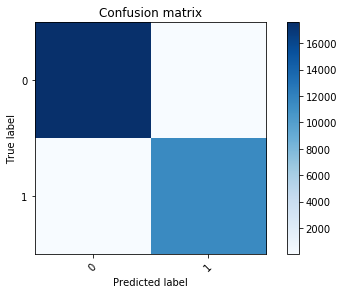

In [236]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_knn_fa, outcome)
plt.show()

In [237]:
print(classification_report(y_adf_test, y_adf_pred_logistic))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99     17589
          1       0.99      0.97      0.98     11528

avg / total       0.98      0.98      0.98     29117



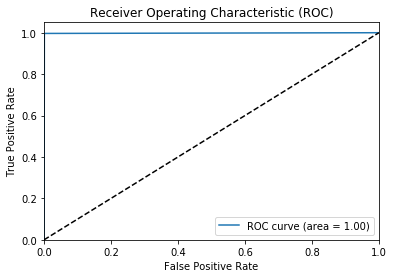

In [238]:
pred_knn_fa = knn.predict(x_adf_test)
pred_knn_fa = pred_knn_fa[:]
plot_roc(pred_knn_fa,y_adf_test)

###  SVM

In [239]:
# SVM
from sklearn.svm import SVC

svm_model = SVC(kernel="linear")

svm_model.fit(x_adf_train, y_adf_train)

y_adf_pred_svm = svm_model.predict(x_adf_test)

In [240]:
# Metrics

score_adf_svm_acc = metrics.accuracy_score(y_adf_test, y_adf_pred_svm)
print("Accuracy score: {}".format(score_adf_svm_acc))

score_adf_svm_precision = metrics.precision_score(y_adf_test, y_adf_pred_svm, average= "weighted")
print("Precision score: {}".format(score_adf_svm_precision))

score_adf_svm_recall = metrics.recall_score(y_adf_test, y_adf_pred_svm, average= "weighted")
print("Recall score: {}".format(score_adf_svm_recall))

score_adf_svm_f1 = metrics.f1_score(y_adf_test, y_adf_pred_svm, average= "weighted")
print("F1 score: {}".format(score_adf_svm_f1))

Accuracy score: 0.9805268399903836
Precision score: 0.9809747688267506
Recall score: 0.9805268399903836
F1 score: 0.980447975698628


In [241]:
cm_svm_fa = confusion_matrix(y_adf_test, y_adf_pred_svm)
print(cm_svm_fa)

[[17554    35]
 [  532 10996]]


In [242]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plotting confusion matrix


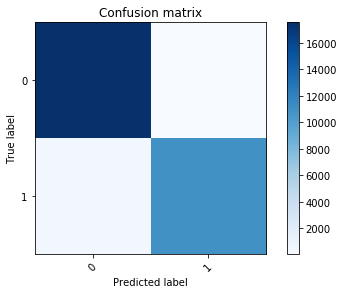

In [243]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_svm_fa, outcome)
plt.show()

In [244]:
print(classification_report(y_adf_test, y_adf_pred_logistic))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99     17589
          1       0.99      0.97      0.98     11528

avg / total       0.98      0.98      0.98     29117



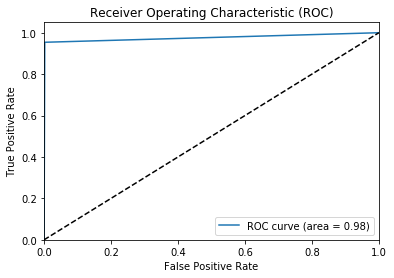

In [245]:
pred_svm_fa = svm_model.predict(x_adf_test)
pred_svm_fa = pred_svm_fa[:]
plot_roc(pred_svm_fa,y_adf_test)

### Gaussian Naive Bayes 

In [246]:
#GNB
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()

gnb_model.fit(x_adf_train, y_adf_train)

y_adf_pred_gnb = gnb_model.predict(x_adf_test)

In [247]:
# Metrics

score_adf_gnb_acc = metrics.accuracy_score(y_adf_test, y_adf_pred_gnb)
print("Accuracy score: {}".format(score_adf_gnb_acc))

score_adf_gnb_precision = metrics.precision_score(y_adf_test, y_adf_pred_gnb, average= "weighted")
print("Precision score: {}".format(score_adf_gnb_precision))

score_adf_gnb_recall = metrics.recall_score(y_adf_test, y_adf_pred_gnb, average= "weighted")
print("Recall score: {}".format(score_adf_gnb_recall))

score_adf_gnb_f1 = metrics.f1_score(y_adf_test, y_adf_pred_gnb, average= "weighted")
print("F1 score: {}".format(score_adf_gnb_f1))

Accuracy score: 0.9782944671497751
Precision score: 0.9785952641646312
Recall score: 0.9782944671497751
F1 score: 0.9782192710782204


In [248]:
cm_gnb_fa = confusion_matrix(y_adf_test, y_adf_pred_gnb)
print(cm_gnb_fa)

[[17488   101]
 [  531 10997]]


In [249]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plotting confusion matrix


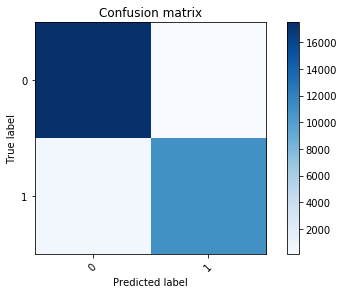

In [250]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_gnb_fa, outcome)
plt.show()

In [251]:
print(classification_report(y_adf_test, y_adf_pred_logistic))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99     17589
          1       0.99      0.97      0.98     11528

avg / total       0.98      0.98      0.98     29117



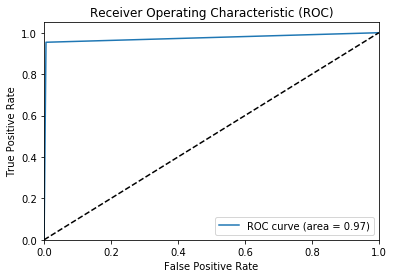

In [252]:
pred_gnb_fa = gnb_model.predict(x_adf_test)
pred_gnb_fa = pred_gnb_fa[:]
plot_roc(pred_gnb_fa,y_adf_test)

### Fully connected Neural Network

In [253]:
#Train test split for feature analysis. Redundancy is removed from data here
x_adf_train, x_adf_test, y_adf_train, y_adf_test = train_test_split(X_new, pd.get_dummies(label_af_df['outcome']).values.astype(np.float32), test_size=0.2, random_state=42)




In [254]:
x_adf_train.shape

(116468, 18)

#### ReLU, adam, 4 layers, early stopping and Model checkpoint  - score_4l

In [255]:
# set up checkpointer
checkpointer_relu_adf = ModelCheckpoint(filepath="./best_weights_relu_4l_nn_adf.hdf5", verbose=1, save_best_only=True)

In [256]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()
    model_reg_relu.add(Dense(10, input_dim=x_adf_train.shape[1], activation='relu'))
    model_reg_relu.add(Dense(50, activation='relu'))
    model_reg_relu.add(Dense(10, activation='relu'))
    model_reg_relu.add(Dense(1))
    model_reg_relu.add(Dense(y_adf_train.shape[1],activation='softmax'))
    model_reg_relu.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_adf_train,y_adf_train,validation_data=(x_adf_test,y_adf_test),callbacks=[monitor,checkpointer_relu_adf ],verbose=2,epochs=1000)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_4l_nn_adf.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/1000
 - 11s - loss: 0.0596 - val_loss: 0.0285

Epoch 00001: val_loss improved from inf to 0.02855, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 2/1000
 - 8s - loss: 0.0188 - val_loss: 0.0143

Epoch 00002: val_loss improved from 0.02855 to 0.01426, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 3/1000
 - 8s - loss: 0.0164 - val_loss: 0.0140

Epoch 00003: val_loss improved from 0.01426 to 0.01401, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 4/1000
 - 8s - loss: 0.0148 - val_loss: 0.0127

Epoch 00004: val_loss improved from 0.01401 to 0.01270, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 5/1000
 - 8s - loss: 0.0139 - val_loss: 0.0101

Epoch 00005: val_loss improved from 0.01270 to 0.01012, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 6/1000
 - 8s - loss: 0.0131 - val_loss: 0.0104

Epoch 00006: val_loss did not improve from 0.01012
Epoch 7/1000
 - 8s - loss: 0.0125 - val_

 - 13s - loss: 0.0589 - val_loss: 0.0283

Epoch 00001: val_loss did not improve from 0.00829
Epoch 2/1000
 - 9s - loss: 0.0221 - val_loss: 0.0141

Epoch 00002: val_loss did not improve from 0.00829
Epoch 3/1000
 - 9s - loss: 0.0176 - val_loss: 0.0130

Epoch 00003: val_loss did not improve from 0.00829
Epoch 4/1000
 - 9s - loss: 0.0161 - val_loss: 0.0118

Epoch 00004: val_loss did not improve from 0.00829
Epoch 5/1000
 - 9s - loss: 0.0147 - val_loss: 0.0132

Epoch 00005: val_loss did not improve from 0.00829
Epoch 6/1000
 - 9s - loss: 0.0138 - val_loss: 0.0119

Epoch 00006: val_loss did not improve from 0.00829
Epoch 7/1000
 - 9s - loss: 0.0132 - val_loss: 0.0102

Epoch 00007: val_loss did not improve from 0.00829
Epoch 8/1000
 - 9s - loss: 0.0122 - val_loss: 0.0100

Epoch 00008: val_loss did not improve from 0.00829
Epoch 9/1000
 - 9s - loss: 0.0119 - val_loss: 0.0086

Epoch 00009: val_loss did not improve from 0.00829
Epoch 10/1000
 - 9s - loss: 0.0115 - val_loss: 0.0094

Epoch 00010:

In [257]:
# Measure accuracy
pred_nn = model_reg_relu.predict(x_adf_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_adf_test,axis=1)

In [258]:
# Metrics

score_tf_acc_relu_adf = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_relu_adf))

score_tf_precision_relu_adf = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_relu_adf))

score_tf_recall_relu_adf = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_relu_adf))

score_tf_f1_relu_adf = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_relu_adf))

Accuracy score: 0.997458529381461
Precision score: 0.9974605511391783
Recall score: 0.997458529381461
F1 score: 0.9974589455556856


In [259]:
cm_relu_adf = confusion_matrix(y_eval, pred_nn)
print(cm_relu_adf)

[[17541    48]
 [   26 11502]]


In [260]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [261]:
outcome

array([0, 1])

Plotting confusion matrix


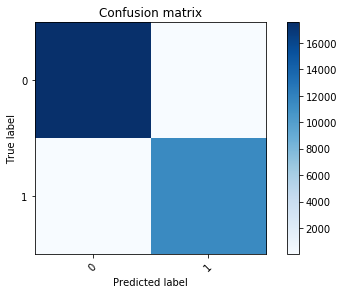

In [262]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_relu_adf, outcome)
plt.show()

In [263]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



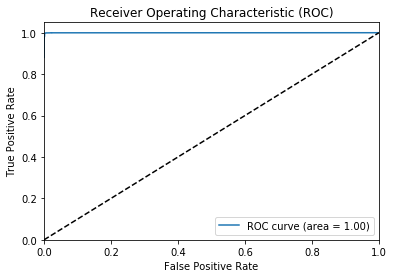

In [264]:
pred_relu_adf = model_reg_relu.predict(x_adf_test)
pred_relu_adf = pred_relu_adf[:,1]
plot_roc(pred_relu_adf,y_eval)

#### Sigmoid, adam, 4 layers  -score_reg_sig_stopping 

In [265]:
# set up checkpointer
checkpointer_sigmoid_adf = ModelCheckpoint(filepath="./best_weights_sigmoid_nn_adf.hdf5", verbose=1, save_best_only=True)

In [266]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_sig = Sequential()

    model_reg_sig.add(Dense(120, input_dim=x_adf_train.shape[1], activation='sigmoid'))  
    model_reg_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_reg_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_reg_sig.add(Dense(y_adf_train.shape[1],activation='softmax')) # Output
    model_reg_sig.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_sig.fit(x_adf_train,y_adf_train,validation_data=(x_adf_test,y_adf_test),callbacks=[monitor,checkpointer_sigmoid_adf],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_sig.load_weights('./best_weights_sigmoid_nn_adf.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 12s - loss: 0.6685 - val_loss: 0.6648

Epoch 00001: val_loss improved from inf to 0.66477, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 2/100
 - 10s - loss: 0.6545 - val_loss: 0.6294

Epoch 00002: val_loss improved from 0.66477 to 0.62935, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 3/100
 - 10s - loss: 0.3922 - val_loss: 0.1365

Epoch 00003: val_loss improved from 0.62935 to 0.13650, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 4/100
 - 11s - loss: 0.1207 - val_loss: 0.1109

Epoch 00004: val_loss improved from 0.13650 to 0.11086, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 5/100
 - 11s - loss: 0.1091 - val_loss: 0.1045

Epoch 00005: val_loss improved from 0.11086 to 0.10446, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 6/100
 - 12s - loss: 0.1020 - val_loss: 0.0959

Epoch 00006: val_loss improved from 0.10446 to 0.09592, saving model to ./best_weights_sigmo


Epoch 00020: val_loss did not improve from 0.05753
Epoch 21/100
 - 11s - loss: 0.0617 - val_loss: 0.0586

Epoch 00021: val_loss did not improve from 0.05753
Epoch 22/100
 - 16s - loss: 0.0614 - val_loss: 0.0582

Epoch 00022: val_loss did not improve from 0.05753
Epoch 23/100
 - 12s - loss: 0.0612 - val_loss: 0.0580

Epoch 00023: val_loss did not improve from 0.05753
Epoch 00023: early stopping
3
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 13s - loss: 0.6711 - val_loss: 0.6688

Epoch 00001: val_loss did not improve from 0.05753
Epoch 2/100
 - 10s - loss: 0.6666 - val_loss: 0.6620

Epoch 00002: val_loss did not improve from 0.05753
Epoch 3/100
 - 10s - loss: 0.6416 - val_loss: 0.5816

Epoch 00003: val_loss did not improve from 0.05753
Epoch 4/100
 - 10s - loss: 0.2759 - val_loss: 0.1217

Epoch 00004: val_loss did not improve from 0.05753
Epoch 5/100
 - 10s - loss: 0.1143 - val_loss: 0.1069

Epoch 00005: val_loss did not improve from 0.05753
Epoch 6/100
 - 10s - los

 - 10s - loss: 0.0602 - val_loss: 0.0569

Epoch 00024: val_loss did not improve from 0.05687
Epoch 25/100
 - 10s - loss: 0.0600 - val_loss: 0.0568

Epoch 00025: val_loss improved from 0.05687 to 0.05679, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 00025: early stopping
6
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 13s - loss: 0.6728 - val_loss: 0.6694

Epoch 00001: val_loss did not improve from 0.05679
Epoch 2/100
 - 9s - loss: 0.6670 - val_loss: 0.6623

Epoch 00002: val_loss did not improve from 0.05679
Epoch 3/100
 - 9s - loss: 0.6430 - val_loss: 0.5874

Epoch 00003: val_loss did not improve from 0.05679
Epoch 4/100
 - 9s - loss: 0.2817 - val_loss: 0.1231

Epoch 00004: val_loss did not improve from 0.05679
Epoch 5/100
 - 9s - loss: 0.1170 - val_loss: 0.1114

Epoch 00005: val_loss did not improve from 0.05679
Epoch 6/100
 - 9s - loss: 0.1095 - val_loss: 0.1044

Epoch 00006: val_loss did not improve from 0.05679
Epoch 7/100
 - 9s - loss: 0.1035 - val_

 - 12s - loss: 0.4241 - val_loss: 0.1478

Epoch 00003: val_loss did not improve from 0.05659
Epoch 4/100
 - 9s - loss: 0.1234 - val_loss: 0.1115

Epoch 00004: val_loss did not improve from 0.05659
Epoch 5/100
 - 10s - loss: 0.1094 - val_loss: 0.1035

Epoch 00005: val_loss did not improve from 0.05659
Epoch 6/100
 - 10s - loss: 0.1023 - val_loss: 0.0963

Epoch 00006: val_loss did not improve from 0.05659
Epoch 7/100
 - 10s - loss: 0.0947 - val_loss: 0.0877

Epoch 00007: val_loss did not improve from 0.05659
Epoch 8/100
 - 11s - loss: 0.0864 - val_loss: 0.0796

Epoch 00008: val_loss did not improve from 0.05659
Epoch 9/100
 - 10s - loss: 0.0792 - val_loss: 0.0729

Epoch 00009: val_loss did not improve from 0.05659
Epoch 10/100
 - 10s - loss: 0.0742 - val_loss: 0.0692

Epoch 00010: val_loss did not improve from 0.05659
Epoch 11/100
 - 10s - loss: 0.0710 - val_loss: 0.0667

Epoch 00011: val_loss did not improve from 0.05659
Epoch 12/100
 - 10s - loss: 0.0687 - val_loss: 0.0654

Epoch 00012

In [267]:
# Measure accuracy
pred_nn = model_reg_sig.predict(x_adf_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_adf_test,axis=1)

In [268]:
# Metrics

score_tf_acc_sig_adf = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_sig_adf))

score_tf_precision_sig_adf = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_sig_adf))

score_tf_recall_sig_adf = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_sig_adf))

score_tf_f1_sig_adf = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_sig_adf))

Accuracy score: 0.9869148607342789
Precision score: 0.9869227666119975
Recall score: 0.9869148607342789
F1 score: 0.986903789403367


In [269]:
cm_sig_adf = confusion_matrix(y_eval, pred_nn)
print(cm_sig_adf)

[[17454   135]
 [  246 11282]]


In [270]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [271]:
outcome

array([0, 1])

Plotting confusion matrix


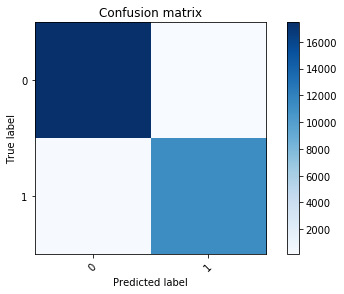

In [272]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_sig_adf, outcome)
plt.show()

In [273]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     17589
          1       0.99      0.98      0.98     11528

avg / total       0.99      0.99      0.99     29117



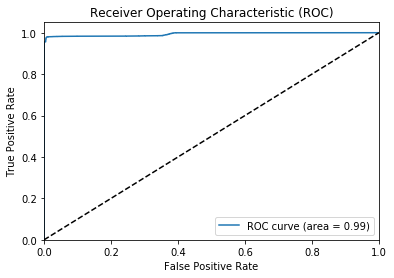

In [274]:
pred_sig_adf = model_reg_sig.predict(x_adf_test)
pred_sig_adf = pred_sig_adf[:,1]
plot_roc(pred_sig_adf,y_eval)

#### Tanh, adam 4 layers score_reg_tanh_stopping

In [275]:
# set up checkpointer
checkpointer_tanh_adf = ModelCheckpoint(filepath="./best_weights_tanh_nn_adf.hdf5", verbose=1, save_best_only=True)


In [276]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_tanh = Sequential()

    model_reg_tanh.add(Dense(120, input_dim=x_adf_train.shape[1], activation='tanh'))  
    model_reg_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_reg_tanh.add(Dense(40, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(y_adf_train.shape[1],activation='softmax')) # Output
    model_reg_tanh.compile(loss='categorical_crossentropy', optimizer='adagrad')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_tanh.fit(x_adf_train,y_adf_train,validation_data=(x_adf_test,y_adf_test),callbacks=[monitor,checkpointer_tanh_adf],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_tanh.load_weights('./best_weights_tanh_nn_adf.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 14s - loss: 0.0518 - val_loss: 0.0395

Epoch 00001: val_loss improved from inf to 0.03954, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 2/100
 - 10s - loss: 0.0310 - val_loss: 0.0197

Epoch 00002: val_loss improved from 0.03954 to 0.01973, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 3/100
 - 10s - loss: 0.0191 - val_loss: 0.0139

Epoch 00003: val_loss improved from 0.01973 to 0.01386, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 4/100
 - 10s - loss: 0.0167 - val_loss: 0.0128

Epoch 00004: val_loss improved from 0.01386 to 0.01283, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 5/100
 - 10s - loss: 0.0155 - val_loss: 0.0121

Epoch 00005: val_loss improved from 0.01283 to 0.01206, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 6/100
 - 10s - loss: 0.0147 - val_loss: 0.0114

Epoch 00006: val_loss improved from 0.01206 to 0.01138, saving model to ./best_weights_tanh_nn_adf.hdf5
Epo

Train on 116468 samples, validate on 29117 samples
Epoch 1/100
 - 17s - loss: 0.0515 - val_loss: 0.0351

Epoch 00001: val_loss did not improve from 0.01034
Epoch 2/100
 - 14s - loss: 0.0288 - val_loss: 0.0221

Epoch 00002: val_loss did not improve from 0.01034
Epoch 3/100
 - 13s - loss: 0.0223 - val_loss: 0.0174

Epoch 00003: val_loss did not improve from 0.01034
Epoch 4/100
 - 13s - loss: 0.0201 - val_loss: 0.0164

Epoch 00004: val_loss did not improve from 0.01034
Epoch 5/100
 - 13s - loss: 0.0186 - val_loss: 0.0148

Epoch 00005: val_loss did not improve from 0.01034
Epoch 6/100
 - 13s - loss: 0.0174 - val_loss: 0.0131

Epoch 00006: val_loss did not improve from 0.01034
Epoch 7/100
 - 13s - loss: 0.0163 - val_loss: 0.0126

Epoch 00007: val_loss did not improve from 0.01034
Epoch 8/100
 - 13s - loss: 0.0155 - val_loss: 0.0120

Epoch 00008: val_loss did not improve from 0.01034
Epoch 9/100
 - 13s - loss: 0.0149 - val_loss: 0.0116

Epoch 00009: val_loss did not improve from 0.01034
Epoc

In [277]:
# Measure accuracy
pred_nn = model_reg_tanh.predict(x_adf_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_adf_test,axis=1)

In [278]:
# Metrics

score_tf_acc_tanh_adf = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_tanh_adf))

score_tf_precision_tanh_adf = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_tanh_adf))

score_tf_recall_tanh_adf = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_tanh_adf))

score_tf_f1_tanh_adf = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_tanh_adf))

Accuracy score: 0.9970463990108871
Precision score: 0.9970511600234251
Recall score: 0.9970463990108871
F1 score: 0.9970471884585685


In [279]:
cm_tanh_adf = confusion_matrix(y_eval, pred_nn)
print(cm_tanh_adf)

[[17528    61]
 [   25 11503]]


In [280]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [281]:
outcome

array([0, 1])

Plotting confusion matrix


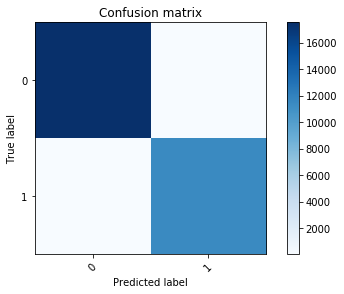

In [282]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_tanh_adf, outcome)
plt.show()

In [283]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       0.99      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



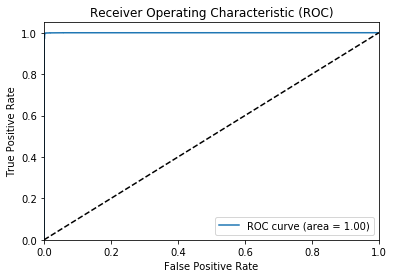

In [284]:
pred_tanh_adf = model_reg_tanh.predict(x_adf_test)
pred_tanh_adf = pred_tanh_adf[:,1]
plot_roc(pred_tanh_adf,y_eval)

### Convolutional Neural Network 

In [285]:
y_new = pd.get_dummies(label_af_df['outcome']).values.astype(np.float32)

In [286]:
y_new.shape

(145585, 2)

In [287]:
x_cnn_train_af, x_cnn_test_af, y_cnn_train_af, y_cnn_test_af = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [288]:
x_cnn_train_af.shape

(116468, 18)

In [289]:
y_cnn_train_af.shape

(116468, 2)

In [290]:
# we now reshape the x_train and x_test to image form used in CNN 2D
x_cnn_train_af = x_cnn_train_af.reshape(x_cnn_train_af.shape[0], 1, x_cnn_train_af.shape[1], 1)
x_cnn_test_af = x_cnn_test_af.reshape(x_cnn_test_af.shape[0], 1, x_cnn_test_af.shape[1], 1)

In [291]:
x_cnn_train_af[0].shape

(1, 18, 1)

In [292]:
checkpointer_cnn_adf = ModelCheckpoint(filepath="./best_weights_cnn_adf.hdf5", verbose=1, save_best_only=True)


In [293]:
# CNN 2D

for i in range(4):
    print(i)

    cnn_adf = Sequential()

# Conv2D layer 1
    cnn_adf.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=x_cnn_train_af[0].shape))
    cnn_adf.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_adf.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_adf.add(Dropout(0.25))
    
    cnn_adf.add(Flatten())

    cnn_adf.add(Dense(164, activation='relu'))

    cnn_adf.add(Dropout(0.5))

    cnn_adf.add(Dense(2, activation='softmax'))

    cnn_adf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn_adf.fit(x_cnn_train_af, y_cnn_train_af, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn_adf], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_cnn_test_af, y_cnn_test_af))

print('Training finished...Loading the best model') 
print()
cnn_adf.load_weights('./best_weights_cnn_adf.hdf5')

0
Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 13s - loss: 0.0529 - acc: 0.9836 - val_loss: 0.0160 - val_acc: 0.9946

Epoch 00001: val_loss improved from inf to 0.01601, saving model to ./best_weights_cnn_adf.hdf5
Epoch 2/10
 - 9s - loss: 0.0199 - acc: 0.9937 - val_loss: 0.0130 - val_acc: 0.9965

Epoch 00002: val_loss improved from 0.01601 to 0.01305, saving model to ./best_weights_cnn_adf.hdf5
Epoch 3/10
 - 9s - loss: 0.0167 - acc: 0.9948 - val_loss: 0.0113 - val_acc: 0.9965

Epoch 00003: val_loss improved from 0.01305 to 0.01132, saving model to ./best_weights_cnn_adf.hdf5
Epoch 4/10
 - 9s - loss: 0.0154 - acc: 0.9956 - val_loss: 0.0100 - val_acc: 0.9970

Epoch 00004: val_loss improved from 0.01132 to 0.00999, saving model to ./best_weights_cnn_adf.hdf5
Epoch 5/10
 - 9s - loss: 0.0139 - acc: 0.9959 - val_loss: 0.0097 - val_acc: 0.9971

Epoch 00005: val_loss improved from 0.00999 to 0.00973, saving model to ./best_weights_cnn_adf.hdf5
Epoch 6/10
 - 9s - loss: 0.013

In [294]:
cnn_af.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 1, 122, 41)        164       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 120, 82)        10168     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 60, 82)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 60, 82)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4920)              0         
_________________________________________________________________
dense_315 (Dense)            (None, 164)               807044    
_________________________________________________________________
dropout_16 (Dropout)         (None, 164)               0         
__________

In [295]:
# Evaluate Accuracy in Keras
score_cnn_adf = cnn_adf.evaluate(x_cnn_test_af, y_cnn_test_af, verbose=0)
score_cnn_adf

[0.007860293622741455, 0.9977332829618436]

In [296]:
pred_cnn_adf = cnn_adf.predict(x_cnn_test_af)
pred_cnn_adf = np.argmax(pred_cnn_adf,axis=1)
pred_cnn_adf

array([0, 1, 0, ..., 1, 1, 1])

In [297]:
y_true_cnn_af = np.argmax(y_cnn_test_af,axis=1)
y_true_cnn_af

array([0, 1, 0, ..., 1, 1, 1])

In [298]:
# Metrics

score_acc_cnn_adf = metrics.accuracy_score(y_true_cnn_af, pred_cnn_adf)
print("Accuracy score: {}".format(score_acc_cnn_adf))

score_precision_cnn_adf = metrics.precision_score(y_true_cnn_af, pred_cnn_adf, average= "weighted")
print("Precision score: {}".format(score_precision_cnn_adf))

score_recall_cnn_adf = metrics.recall_score(y_true_cnn_af, pred_cnn_adf, average= "weighted")
print("Recall score: {}".format(score_recall_cnn_adf))

score_f1_cnn_adf = metrics.f1_score(y_true_cnn_af, pred_cnn_adf, average= "weighted")
print("F1 score: {}".format(score_f1_cnn_adf))

Accuracy score: 0.9977332829618436
Precision score: 0.9977349414187415
Recall score: 0.9977332829618436
F1 score: 0.997733620522209


In [299]:
cm_cnn_adf = confusion_matrix(y_true_cnn_af, pred_cnn_adf)
print(cm_cnn_adf)

[[17546    43]
 [   23 11505]]


In [300]:
outcome = encode_text_index(label_af_df,'outcome')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Plotting confusion matrix


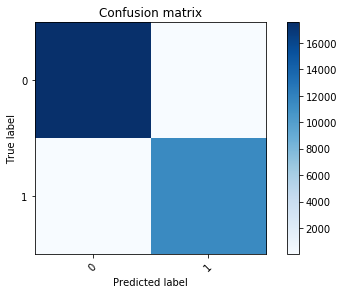

In [301]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn_adf, outcome)
plt.show()

In [302]:
print(classification_report(y_true_cnn_af, pred_cnn_adf))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



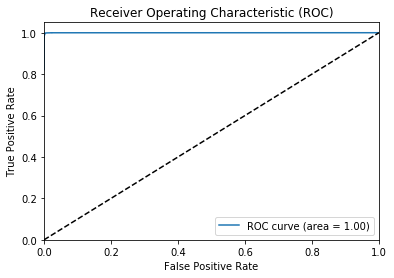

In [303]:
pred_cnn_adf = cnn_adf.predict(x_cnn_test_af)
pred_cnn_adf = pred_cnn_adf[:,1]
plot_roc(pred_cnn_adf,y_true_cnn_af)

## Experimenting with other proven CNN architecture 

### Data Processing for new CNN

In [304]:
#Read network_intrusion_data.csv file and load data into network_df dataframe 
network_cnn_af_df= pd.read_csv('network_intrusion_data.csv')

In [305]:
#Drop any row with missing values
network_cnn_af_df = network_cnn_af_df.dropna()

In [306]:
#Add column headers to the data in the dataframe
network_cnn_af_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [307]:
network_cnn_af_df.drop_duplicates(keep='first', inplace=True)

In [308]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(network_cnn_af_df,"duration") 
normalize_numeric_minmax(network_cnn_af_df,"src_bytes") 
normalize_numeric_minmax(network_cnn_af_df,"dst_bytes") 
normalize_numeric_minmax(network_cnn_af_df,"wrong_fragment") 
normalize_numeric_minmax(network_cnn_af_df,"urgent") 

normalize_numeric_minmax(network_cnn_af_df,"hot") 
normalize_numeric_minmax(network_cnn_af_df,"num_failed_logins") 
normalize_numeric_minmax(network_cnn_af_df,"num_compromised") 
normalize_numeric_minmax(network_cnn_af_df,"num_root") 
normalize_numeric_minmax(network_cnn_af_df,"num_file_creations") 
normalize_numeric_minmax(network_cnn_af_df,"num_shells") 
normalize_numeric_minmax(network_cnn_af_df,"num_access_files") 
normalize_numeric_minmax(network_cnn_af_df,"num_outbound_cmds") 

normalize_numeric_minmax(network_cnn_af_df,"count") 
normalize_numeric_minmax(network_cnn_af_df,"srv_count") 
normalize_numeric_minmax(network_cnn_af_df,"serror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"rerror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"srv_rerror_rate")  
normalize_numeric_minmax(network_cnn_af_df,"same_srv_rate") 
normalize_numeric_minmax(network_cnn_af_df,"diff_srv_rate") 
normalize_numeric_minmax(network_cnn_af_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_count") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_srv_rerror_rate") 

In [309]:
#One hot coding discrete values (9)
encode_text_dummy(network_cnn_af_df,"protocol_type") 
encode_text_dummy(network_cnn_af_df,"service") 
encode_text_dummy(network_cnn_af_df,"flag") 
encode_text_dummy(network_cnn_af_df,"land") 
encode_text_dummy(network_cnn_af_df,"logged_in") 
encode_text_dummy(network_cnn_af_df,"root_shell") 
encode_text_dummy(network_cnn_af_df,"su_attempted") 
encode_text_dummy(network_cnn_af_df,"is_host_login") 
encode_text_dummy(network_cnn_af_df,"is_guest_login") 

In [310]:
#Reduce the data set as the original is too large for classics to run for testing. Remove this section later
#network_cnn_af_df = network_cnn_af_df[0:40000]

In [311]:
#Binary encode the label column
network_cnn_af_df['outcome'] = network_cnn_af_df['outcome'].apply(encodeLabelBinary)

In [312]:
# to xy to convert pandas to tensor flow
x_af,y_af=to_xy(network_cnn_af_df,"outcome")

In [313]:
x_af.shape

(145585, 124)

In [314]:
y_af.shape

(145585, 2)

In [315]:
x_train, x_test, y_train, y_test = train_test_split(x_af,y_af, test_size=0.2, random_state=42)

In [316]:
x_train = x_train.reshape(x_train.shape[0], 1,x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], 1,x_test.shape[1], 1)

### CNN Model

In [317]:
checkpointer_cnn_exp = ModelCheckpoint(filepath="./best_weights_cnn_exp.hdf5", verbose=1, save_best_only=True)

In [318]:
# CNN 2D

for i in range(4):
    print(i)
    
    cnn_exp = Sequential()

    cnn_exp.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1),
                       padding='valid',
                       activation='relu',
                       input_shape=x_train[1].shape))
    
    cnn_exp.add(Conv2D(41, (1, 3), activation='relu'))

    cnn_exp.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_exp.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_exp.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_exp.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_exp.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_exp.add(Conv2D(164, (1, 3), activation='relu'))

    cnn_exp.add(Conv2D(164, (1, 3), activation='relu'))

    cnn_exp.add(Conv2D(164, (1, 3), activation='relu'))

    cnn_exp.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_exp.add(Flatten())
    
    cnn_exp.add(Dense(100, activation='relu'))

    cnn_exp.add(Dropout(0.5))

    cnn_exp.add(Dense(20, activation='relu'))

    cnn_exp.add(Dense(2, activation='softmax'))
    
    cnn_exp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn_exp.fit(x_train, y_train,
                batch_size=128,
                callbacks=[monitor,checkpointer_cnn_exp],
                epochs=10,
                verbose=2,
                validation_data=(x_test, y_test))
    
print('Training finished...Loading the best model') 
print()
cnn_exp.load_weights('./best_weights_cnn_exp.hdf5')


0
Train on 116468 samples, validate on 29117 samples
Epoch 1/10
 - 89s - loss: 0.0447 - acc: 0.9843 - val_loss: 0.0175 - val_acc: 0.9933

Epoch 00001: val_loss improved from inf to 0.01752, saving model to ./best_weights_cnn_exp.hdf5
Epoch 2/10
 - 83s - loss: 0.0198 - acc: 0.9934 - val_loss: 0.0090 - val_acc: 0.9967

Epoch 00002: val_loss improved from 0.01752 to 0.00902, saving model to ./best_weights_cnn_exp.hdf5
Epoch 3/10
 - 83s - loss: 0.0119 - acc: 0.9963 - val_loss: 0.0066 - val_acc: 0.9982

Epoch 00003: val_loss improved from 0.00902 to 0.00661, saving model to ./best_weights_cnn_exp.hdf5
Epoch 4/10
 - 84s - loss: 0.0094 - acc: 0.9972 - val_loss: 0.0056 - val_acc: 0.9982

Epoch 00004: val_loss improved from 0.00661 to 0.00557, saving model to ./best_weights_cnn_exp.hdf5
Epoch 5/10
 - 87s - loss: 0.0091 - acc: 0.9974 - val_loss: 0.0071 - val_acc: 0.9977

Epoch 00005: val_loss did not improve from 0.00557
Epoch 6/10
 - 83s - loss: 0.0084 - acc: 0.9976 - val_loss: 0.0048 - val_acc

In [319]:
# Evaluate Accuracy in Keras
score = cnn_exp.evaluate(x_test, y_test, verbose=0)
score

[0.004361782233029317, 0.9986605762956349]

In [320]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.004361782233029317
Test accuracy: 0.9986605762956349


In [321]:
pred_cnn_exp = cnn_exp.predict(x_test)
pred_cnn_exp = np.argmax(pred_cnn_exp,axis=1)

In [322]:
pred_cnn_exp

array([0, 1, 0, ..., 1, 1, 1])

In [323]:
y_true_cnn_exp = np.argmax(y_test,axis=1)
y_true_cnn_exp

array([0, 1, 0, ..., 1, 1, 1])

In [324]:
# Metrics

score_acc_cnn_exp = metrics.accuracy_score(y_true_cnn_exp, pred_cnn_exp)
print("Accuracy score: {}".format(score_acc_cnn_exp))

score_precision_cnn_exp = metrics.precision_score(y_true_cnn_exp, pred_cnn_exp, average= "weighted")
print("Precision score: {}".format(score_precision_cnn_exp))

score_recall_cnn_exp = metrics.recall_score(y_true_cnn_exp, pred_cnn_exp, average= "weighted")
print("Recall score: {}".format(score_recall_cnn_exp))

score_f1_cnn_exp = metrics.f1_score(y_true_cnn_exp, pred_cnn_exp, average= "weighted")
print("F1 score: {}".format(score_f1_cnn_exp))

Accuracy score: 0.9986605762956349
Precision score: 0.9986607317324747
Recall score: 0.9986605762956349
F1 score: 0.9986604458692393


In [325]:
cm_cnn_exp = confusion_matrix(y_true_cnn_exp, pred_cnn_exp)
print(cm_cnn_exp)

[[17576    13]
 [   26 11502]]


In [326]:
outcome = encode_text_index(network_cnn_af_df,'outcome')

In [327]:
outcome

array([0, 1])

Plotting confusion matrix


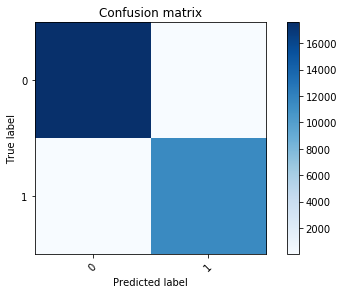

In [328]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn_exp, outcome)
plt.show()

In [329]:
print(classification_report(y_true_cnn_exp, pred_cnn_exp))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



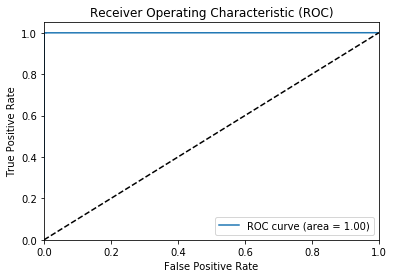

In [331]:
pred_cnn_exp = cnn_exp.predict(x_test)
pred_cnn_exp = pred_cnn_exp[:,1]
plot_roc(pred_cnn_exp,y_true_cnn_exp)